## Astronomy 534 "Extragalactic Universe" (Winter 2025)

## Project 2

####  Brigette Vazquez Segovia

In this notebook I solve the problem of: Using the IllustrisTNG simulation dataset to investigate the properties of simulated galaxies. 


# Abstract

In this project I demonstrate ways in which one can calculate a more accurate halo mass function by using either TNG-300 or TNG-50. I show the differences between the central and satellite star formation rates. I also test the limitations of both TNG-50 and TNG-300. In order to test the limitations of both datasets from Illustris TNG, I run several tests, I check their mass sigma relation, their differential mass functions, their cumulative mass functions, their cumulative mass density, and mass ratios between a stellar model and the DM haloes. The main reson for these tests was to explore under what conditions would each TNG model be applicable and reliable when developing more accurate mathematical descriptions for things like the mass function. Additionally, I demonstrate a way to implement an algorithm to help determine the two point correlation function for both datasets, and show how this compares to Springel et al. 2005's work. 

# Introduction 
Illsutris-TNG provides a high resolution simulation of galaxy formation and evolution. I focus on the final snapshots of the simulation (z=0), which would desmonstrate our present day universe. TNG contains powerful computational resources able to reproduce one of the most accurate datasets of universe developments. It is calibrated using the initial conditions of $\Lambda CDM$. For the purposes of this project I use the TNG-50 and TNG-300 (the main reason for not using TNG-150 as well was due to storage issues). The datasets downloaded are the Download FoF & Subfind, not the snapshots. Simulation models allow us to have a more complete picture of what we expect to have as mass functions for DM haloes in our universe. This helps us define these functions with higher accuracy, rather than depending on a scarce amount of data. 

The two-point correlation function (often labeled as 2PCF) reveals how the density of objects, like galaxies, varies with distance. The 2PCF can be thought of a way to quantify how much clustering is happening within a given distribution, or how often does the data tend to be clumped together versus spread apart. The 2PCF is highly relevant if one is studying things such as galaxy clustering. The purpose of visualizing it for our dataset is to briefly attempt to visualize the morphology of a universe like ours. 




Below is a brief description of the TNG datasets:

| Quantity                    | Unit            | TNG50           | TNG300          |
|:----------------------------|:---------------:|----------------:|----------------:|
| Volume                      | [Mpc$^3$]       | $51.7^3$        | $302.6^3$       |
| $L_{\rm box}$               | [Mpc/$h$]       | 35              | 205             |
| $N_{\rm GAS}$               | —               | $2160^3$        | $2500^3$        |
| $N_{\rm DM}$                | —               | $2160^3$        | $2500^3$        |
| $N_{\rm TR}$                | —               | $2160^3$        | $2500^3$        |
| $m_{\rm baryon}$            | [$M_{\odot}$]   | $8.5\times10^4$ | $1.1\times10^7$ |
| $m_{\rm DM}$                | [$M_{\odot}$]   | $4.5\times10^5$ | $5.9\times10^7$ |
| $\epsilon_{\rm gas,min}$    | [pc]            | 74              | 370             |
| $\epsilon_{\rm DM,\star}$   | [pc]            | 288             | 1480            |


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.special import erf
from colossus.cosmology import power_spectrum
from colossus.cosmology import cosmology
from colossus.lss import mass_function

import astropy.constants as const
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.stats import linregress
import h5py
import sys
sys.path.append('/Users/bsegovia/Downloads/ASTRO_534/illustris_python')
import illustris_python as il

# set the default plotting parameters
plt.rcParams.update({
    'savefig.bbox': 'tight',
    'savefig.dpi': 200,
    'figure.dpi': 200,
    'lines.linewidth': 1.5,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Verdana',
    'font.size': 10,
    'axes.labelsize': 15,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.major.pad': 5,
    'xtick.minor.pad': 5,
    'ytick.major.pad': 5,
    'ytick.minor.pad': 5,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': False,
    'text.usetex': True
})

import pandas as pd

# This data is from Springel et al. 2005. Figure 4. I used a wedplot diagram (online tool) to find the values in the figure, for future comparison to my data below. 
obs = pd.read_csv('/Users/bsegovia/Downloads/obs.csv', header=None, names=['x','y'])
obs


,x,y
0,0.244864,148.842609
1,0.342458,118.229887
2,0.436454,53.366992
3,0.585742,32.291700
4,0.777689,22.154122
5,1.077449,11.103363
6,1.572875,5.682579
7,2.224072,3.585465
8,3.048388,2.037469
9,4.220176,1.427399


### First we load the TNG-50 and TNG-300 data

In [2]:
# Set the simulation base path and snapshot number
basePath = '/Users/bsegovia/Downloads/ASTRO_534/TNG300-1'
basepath2 = '/Users/bsegovia/Downloads/ASTRO_534/TNG50-1'
snap = 99

# Load subhalo data (mass, SFR, spin, and gas metallicity)
fields = ['SubhaloMass', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloGasMetallicity']

subhalos300 = il.groupcat.loadSubhalos(basePath, 99, fields=fields) # change 135 to 99 
subhalos50 = il.groupcat.loadSubhalos(basepath2, 99, fields=fields) # change 135 to 99

In [3]:
# Convert subhalo mass to physical units (Msun/h) and get SFR
mh = subhalos300['SubhaloMass'] * 1e10    # halo mass in Msun/h for TNG300
mh2 = subhalos50['SubhaloMass'] * 1e10    # halo mass in Msun/h for TNG50

sfr = subhalos300['SubhaloSFRinRad']      # SFR in Msun/yr for TNG300
sfr2 = subhalos50['SubhaloSFRinRad']      # SFR in Msun/yr for TNG50

# Central & Satellite Galaxies

We plot the central and satellite galaxies by extracting the 'GroupFirstSub' data which corresponds to the centrals of the haloes. Anything that is not a central is then considered a satellite. 

In [4]:
# first we load the group data and get the central index of each group
fields_group = ['GroupFirstSub']
groups = il.groupcat.loadObjects(basePath, snap, "Group", "groups", fields_group)
groups2 = il.groupcat.loadObjects(basepath2, snap, "Group", "groups", fields_group)

group_first_sub = groups
group_first_sub2 = groups2

###########

central_mask = np.zeros(len(mh), dtype=bool)                # Initialize the central mask for TNG300
central_mask[group_first_sub] = True                        # Only assign True for valid indices
satellite_mask = ~central_mask                              # Satellites are those that are not centrals

central_mask2 = np.zeros(len(mh2), dtype=bool)              # Initialize the central mask for TNG50
central_mask2[group_first_sub2] = True                      # Only assign True for valid indices
satellite_mask2 = ~central_mask2                            # Satellites are those that are not centrals


/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2601421391.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/bsegovia/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


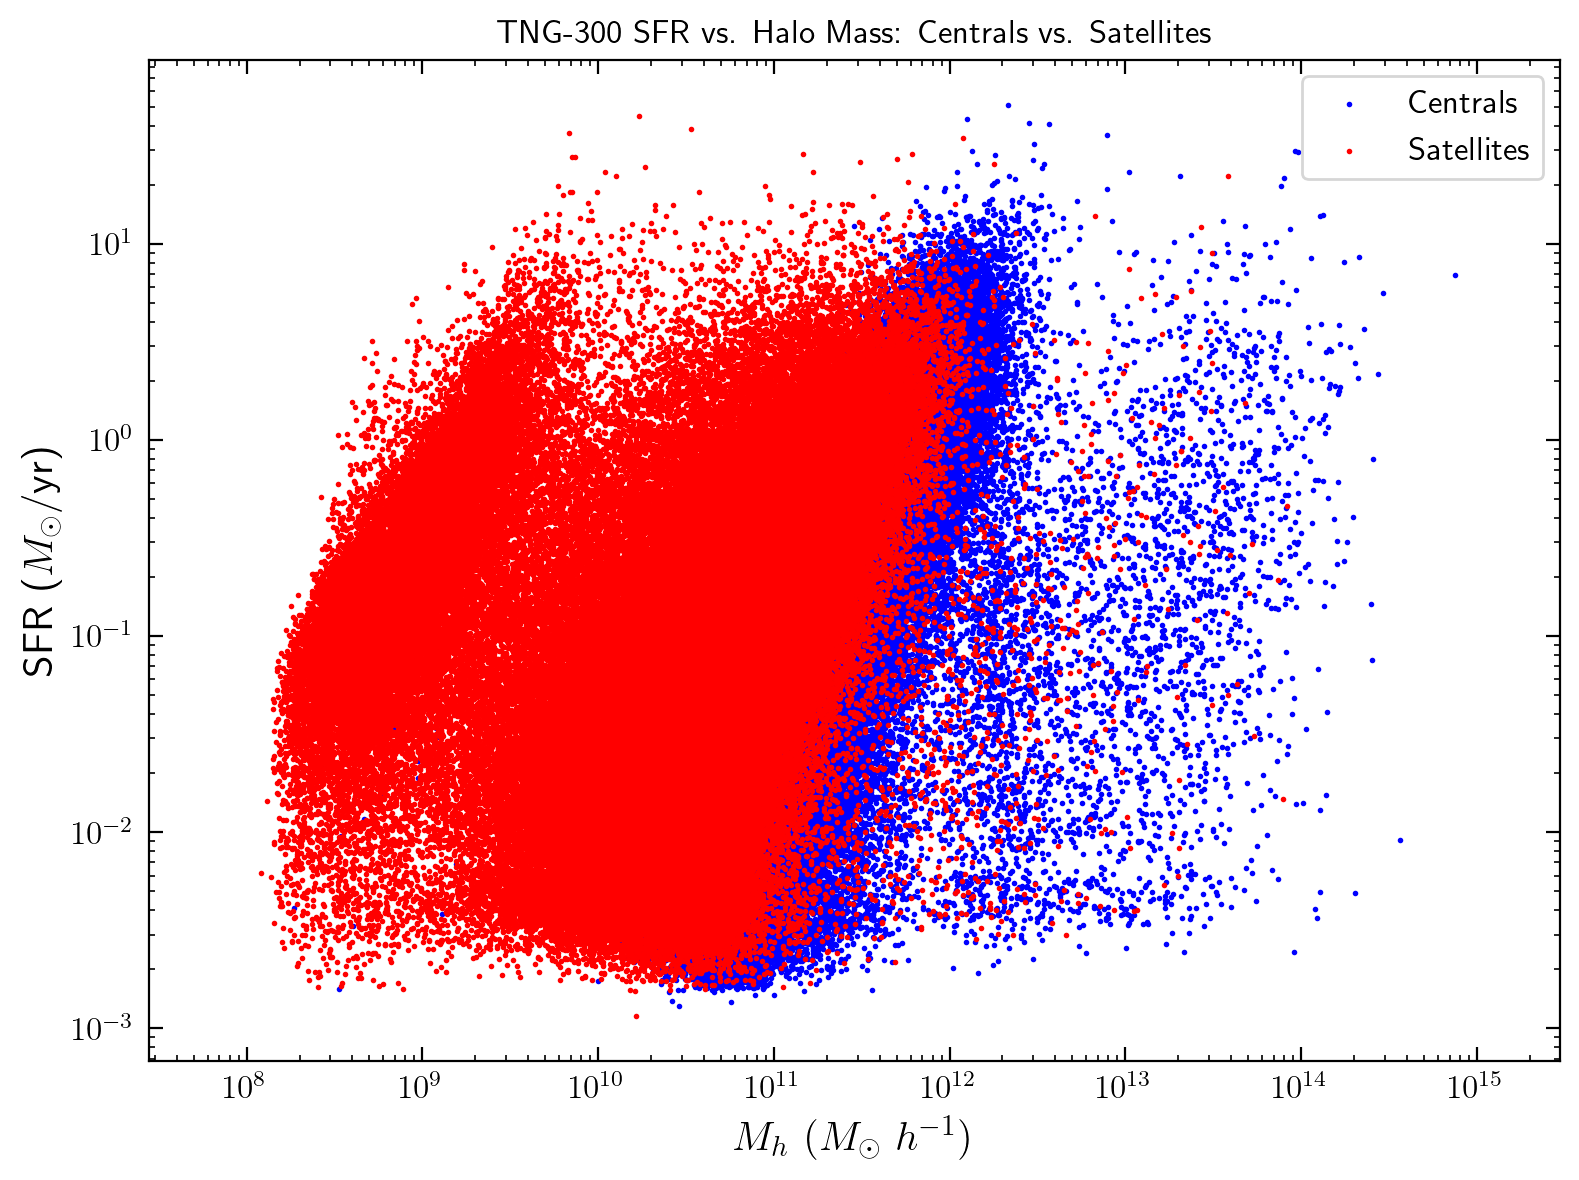

In [5]:
# SFR for centrals and satellites VS Halo Mass
plt.figure(figsize=(8, 6))
plt.scatter(mh[central_mask], sfr[central_mask], s=1, c='blue', label='Centrals')
plt.scatter(mh[satellite_mask], sfr[satellite_mask], s=1, c='red', label='Satellites')
plt.xlabel(r'$M_h \ ( M_\odot \ h^{-1})$')
plt.ylabel(r'SFR ($M_\odot$/yr)')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True)
plt.title('TNG-300 SFR vs. Halo Mass: Centrals vs. Satellites')
plt.tight_layout()
plt.show()


/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/4062232513.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


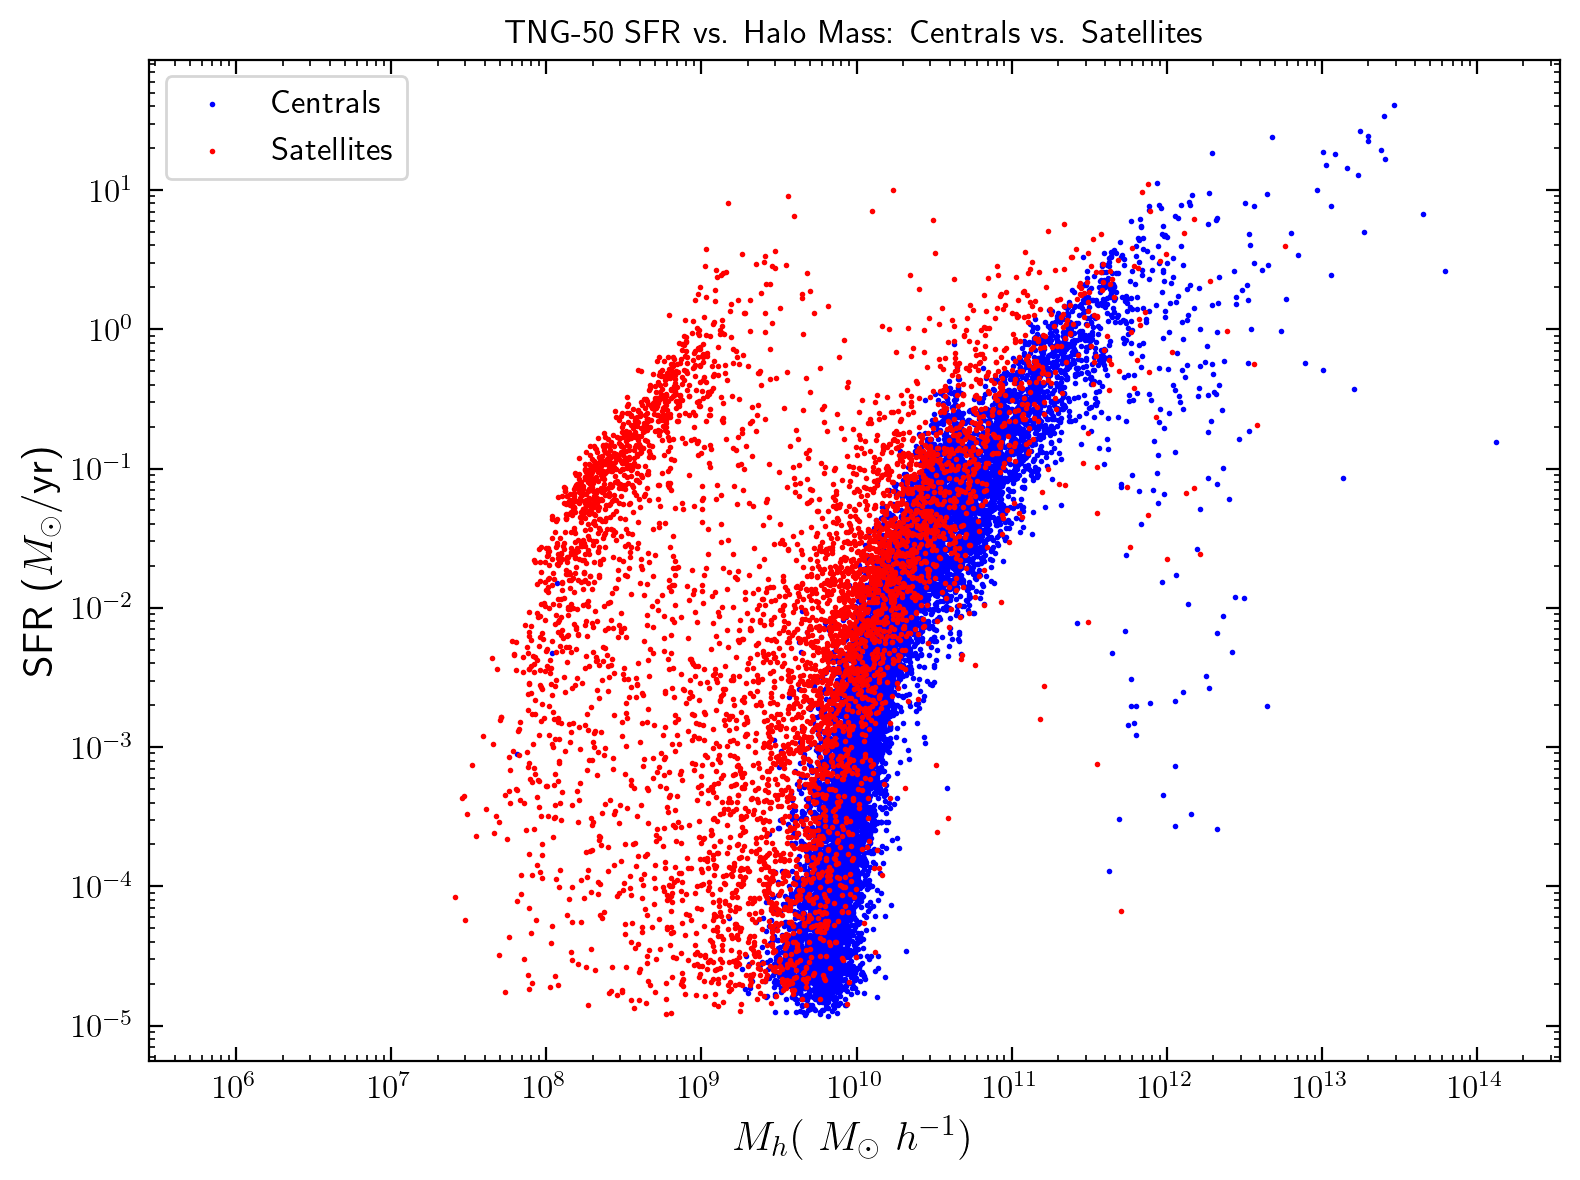

In [6]:
# SFR for centrals and satellites VS Halo Mass
plt.figure(figsize=(8, 6))
plt.scatter(mh2[central_mask2], sfr2[central_mask2], s=1, c='blue', label='Centrals')
plt.scatter(mh2[satellite_mask2], sfr2[satellite_mask2], s=1, c='red', label='Satellites')
plt.xlabel(r'$M_h ( \ M_\odot \ h^{-1})$')
plt.ylabel(r'SFR ($M_\odot$/yr)')
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True)
plt.title('TNG-50 SFR vs. Halo Mass: Centrals vs. Satellites')
plt.tight_layout()
plt.show()


Through a simple visualization of the Centrals and Satellites found in the friends of friends dataset for both TNG300 and TNG50, it is clear that we are able to correctly separate the centrals which overall have a higher mass than the satellites. Additionally, this visualization helps us recognize the mass range difference between TNG300 and TNG50. It is clear that TNG50 has more haloes in the $10^7$ - $10^{12}$ regime compared to TNG 300 which has haloes in the mass range $10^8$ - $10^{14}$. This is akin to their resolution. 

Central galaxies have a slightly higher SFR, but regardless, for both central and satellite, they span approximately the same range of SFR. 

# Constructing the Halo Mass Function

To construct a Halo Mass Function, I use a simple power law:  
\begin{equation}
   \frac{dn}{d\ln M} = A \left(\frac{M_{halo}}{M_{\odot}} \right)^{\alpha}
\end{equation}  

Below I solve for A (the constant) and alpha (the slope) using the TNG-300 and TNG-50 data separately. 

In [7]:
# Define a simple power-law function
def power_law(m, A, alpha):
    m0 = 1e12  # pivot mass in Msun/h
    return A * (m / m0)**alpha

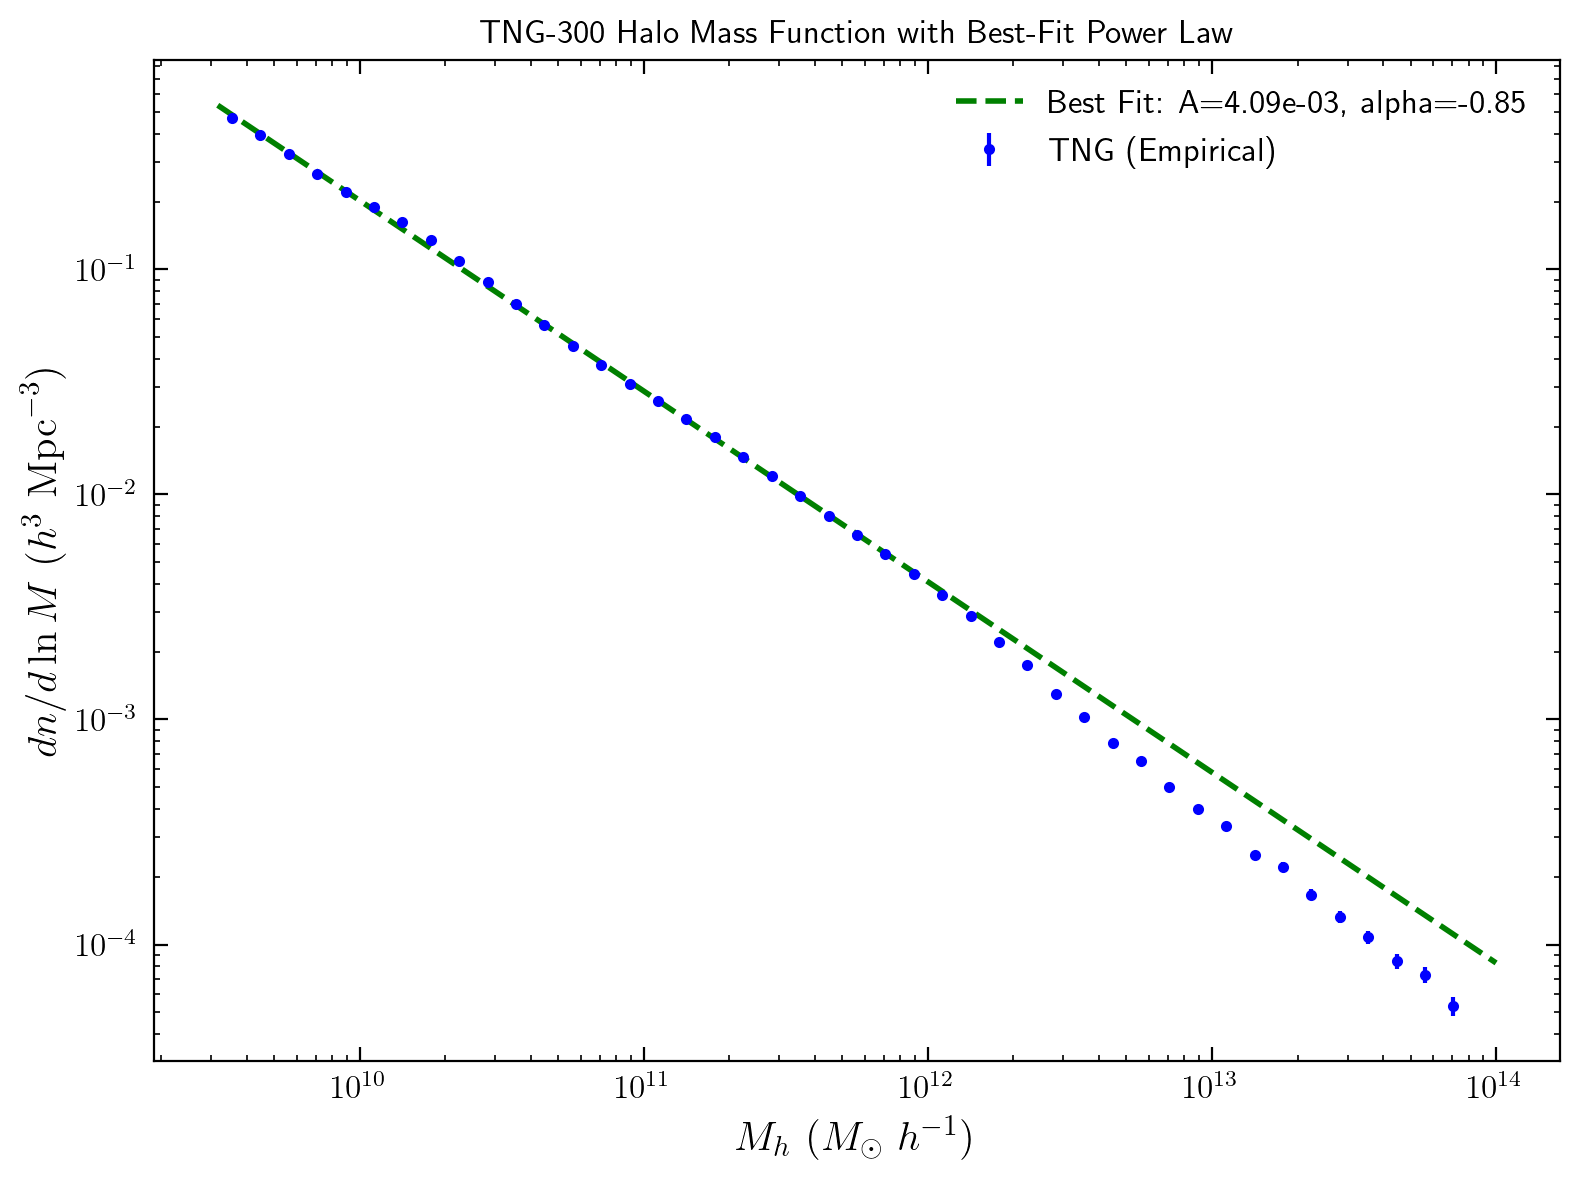

In [8]:
# Define logarithmic bins in mass
d = 0.1
mbins = np.arange(9.5, 14, d)               # logarithm (base 10) range of masses
bins = 10**mbins                            # convert to linear scale
m = 10.**(mbins[:-1] + d/2.)                # midpoints for plotting

dndM, bin_edges = np.histogram(mh, bins=bins, density=False)

# normalize the counts of halos by the volume of the simulation
Lbox = 205.0                                # size of TNG300 box as seen on illustris documentation
dndM = np.array(dndM,'float64') / Lbox**3 / d / np.log(10.)

# Count number of halos in each mass bin
counts, bin_edges = np.histogram(mh, bins=bins, density=False)

# Calculate Poisson errors: sqrt(N) and normalize by volume and bin width.
volume = Lbox**3
errors = np.sqrt(counts.astype(np.float64)) / volume / d / np.log(10.)


fit_mask = counts > 0                        # Mask to avoid fitting bins with zero counts

# Use curve_fit with the errors to weight the fit
popt, pcov = curve_fit(power_law, m[fit_mask], dndM[fit_mask], sigma=errors[fit_mask], absolute_sigma=True, p0=[1e-5, -1.0])
A_fit, alpha_fit = popt


# Best fit curve for plotting
m_fit = np.logspace(9.5, 14, 200)
fit_curve = power_law(m_fit, A_fit, alpha_fit)

# Halo Mass Function with Best-Fit Power Law
plt.figure(figsize=(8, 6))
plt.errorbar(m, dndM, yerr=errors, fmt='o', markersize=3, color='blue', label='TNG (Empirical)')
plt.plot(m_fit, fit_curve, 'g--', lw=2, label=f'Best Fit: A={A_fit:.2e}, alpha={alpha_fit:.2f}')
plt.xlabel(r'$M_h \ ( M_\odot \ h^{-1})$')
plt.ylabel(r'$dn/d\ln M \ (h^{3}\ \mathrm{Mpc}^{-3})$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('TNG-300 Halo Mass Function with Best-Fit Power Law')
plt.tight_layout()
plt.show()


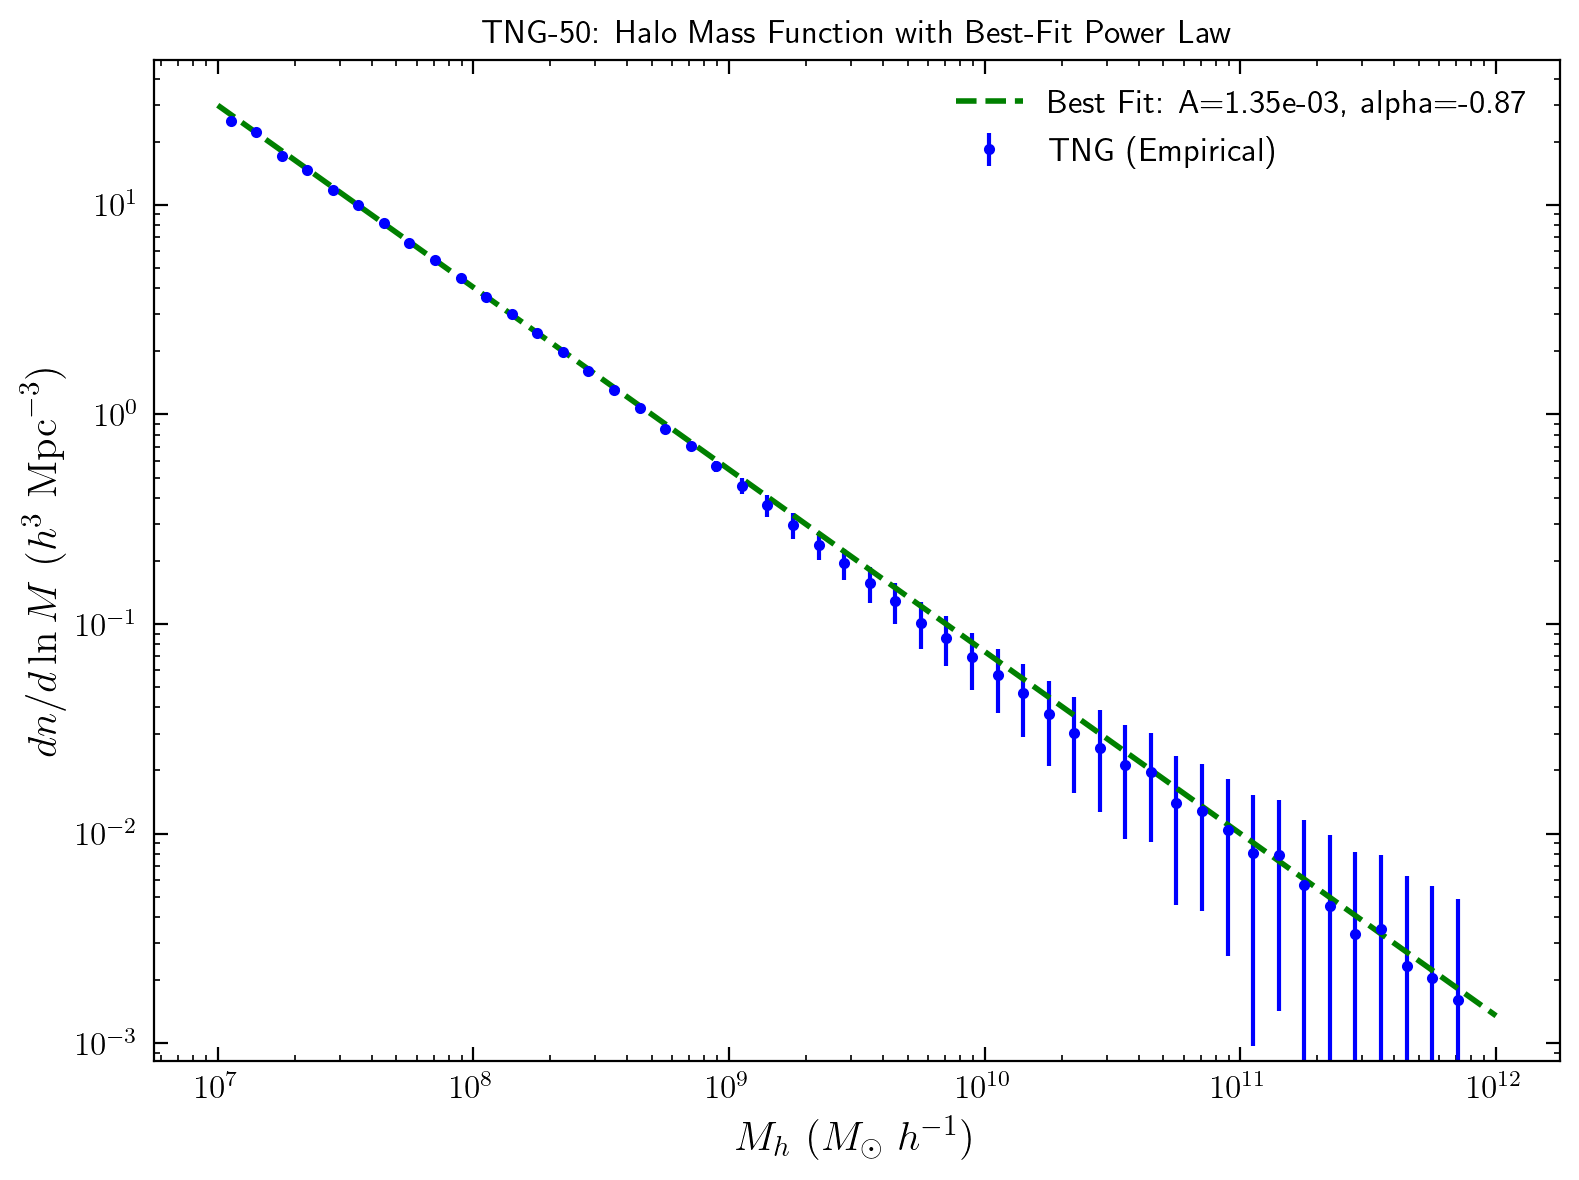

In [9]:
# Define logarithmic bins in mass
d2 = 0.1
mbins2 = np.arange(7, 12, d2)               # logarithm (base 10) range of masses
bins2 = 10**mbins2                            # convert to linear scale
m2 = 10.**(mbins2[:-1] + d2/2.)                # midpoints for plotting

dndM2, bin_edges2 = np.histogram(mh2, bins=bins2, density=False)

# normalize the counts of halos by the volume of the simulation
Lbox2 = 51.7                                  # size of TNG50 box as seen on illustris documentation
dndM2 = np.array(dndM2,'float64') / Lbox2**3 / d2 / np.log(10.)

# Count number of halos in each mass bin
counts2, bin_edges2 = np.histogram(mh, bins=bins2, density=False)

# Calculate Poisson errors: sqrt(N) and normalize by volume and bin width.
volume2 = Lbox2**3
errors2 = np.sqrt(counts2.astype(np.float64)) / volume2 / d2 / np.log(10.)


fit_mask2 = counts2 > 0                        # Mask to avoid fitting bins with zero counts

# Use curve_fit with the errors to weight the fit
popt2, pcov2 = curve_fit(power_law, m2[fit_mask2], dndM2[fit_mask2], sigma=errors2[fit_mask2], absolute_sigma=True, p0=[1e-5, -1.0])
A_fit2, alpha_fit2 = popt2


# Best fit curve for plotting
m_fit2 = np.logspace(7, 12, 200)
fit_curve2 = power_law(m_fit2, A_fit2, alpha_fit2)

# Halo Mass Function with Best-Fit Power Law
plt.figure(figsize=(8, 6))
plt.errorbar(m2, dndM2, yerr=errors2, fmt='o', markersize=3, color='blue', label='TNG (Empirical)')
plt.plot(m_fit2, fit_curve2, 'g--', lw=2, label=f'Best Fit: A={A_fit2:.2e}, alpha={alpha_fit2:.2f}')
plt.xlabel(r'$M_h \ ( M_\odot \ h^{-1})$')
plt.ylabel(r'$dn/d\ln M \ (h^{3}\ \mathrm{Mpc}^{-3})$')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e8, 1e12)
plt.legend()
plt.title('TNG-50: Halo Mass Function with Best-Fit Power Law')
plt.tight_layout()
plt.show()


In [10]:
print(f'The best fit parameters for TNG-300 where A = {A_fit:.2e} and alpha = {alpha_fit:.2f}')
print(f'The best fit parameters for TNG-50 where A = {A_fit2:.2e} and alpha = {alpha_fit2:.2f}')


print(f'The range of halo masses used for calculation for TNG-300 is from {m_fit[0]:.2e} to {m_fit[-1]:.2e}')
print(f'The range of halo masses used for calculation for TNG-50 is from {m_fit2[0]:.2e} to {m_fit2[-1]:.2e}')

The best fit parameters for TNG-300 where A = 4.09e-03 and alpha = -0.85
The best fit parameters for TNG-50 where A = 1.35e-03 and alpha = -0.87
The range of halo masses used for calculation for TNG-300 is from 3.16e+09 to 1.00e+14
The range of halo masses used for calculation for TNG-50 is from 1.00e+07 to 1.00e+12


When developing the Haloe Mass function, it is clear that the range for which TNG50 and TNG300 can get us reulst is different. I had to trim out certain regions to only account for data that was not too noisy (this was determined visually). The best fit parameters plugged into our Halo Mass Function are as follows:  

For TNG 300 it is:
\begin{equation}
\frac{dn}{d\ln M} = 4.09\times 10^{-3} \left( \frac{M_{halo}}{M_{\odot}} \right)^{-0.85}
\end{equation}

For TNG 50 it is:
\begin{equation}
\frac{dn}{d\ln M} = 1.35\times 10^{-3} \left( \frac{M_{halo}}{M_{\odot}} \right)^{-0.87}
\end{equation}

Both of these agree on the same order of magnitude for the coefficient in the front, and have very similar values for the slope. Given the errors plotted above on the TNG data, and the inability to perfectly fit the higher mass range for both simulation datasets, one may agree that these results agree with each other.

# Comparing with Colossus

In [11]:
# Define Planck 2018 cosmological parameters
h100 = 0.677
Om0 = 0.1424 / h100**2
Ob0 = 0.0224 / h100**2
ns = 0.967
sigma8 = 0.81

cosmo = cosmology.setCosmology('my_cosmo', {'flat':True, 'H0':100*h100, 'Om0':Om0, 'Ob0':Ob0, 'sigma8':sigma8, 'ns':ns})

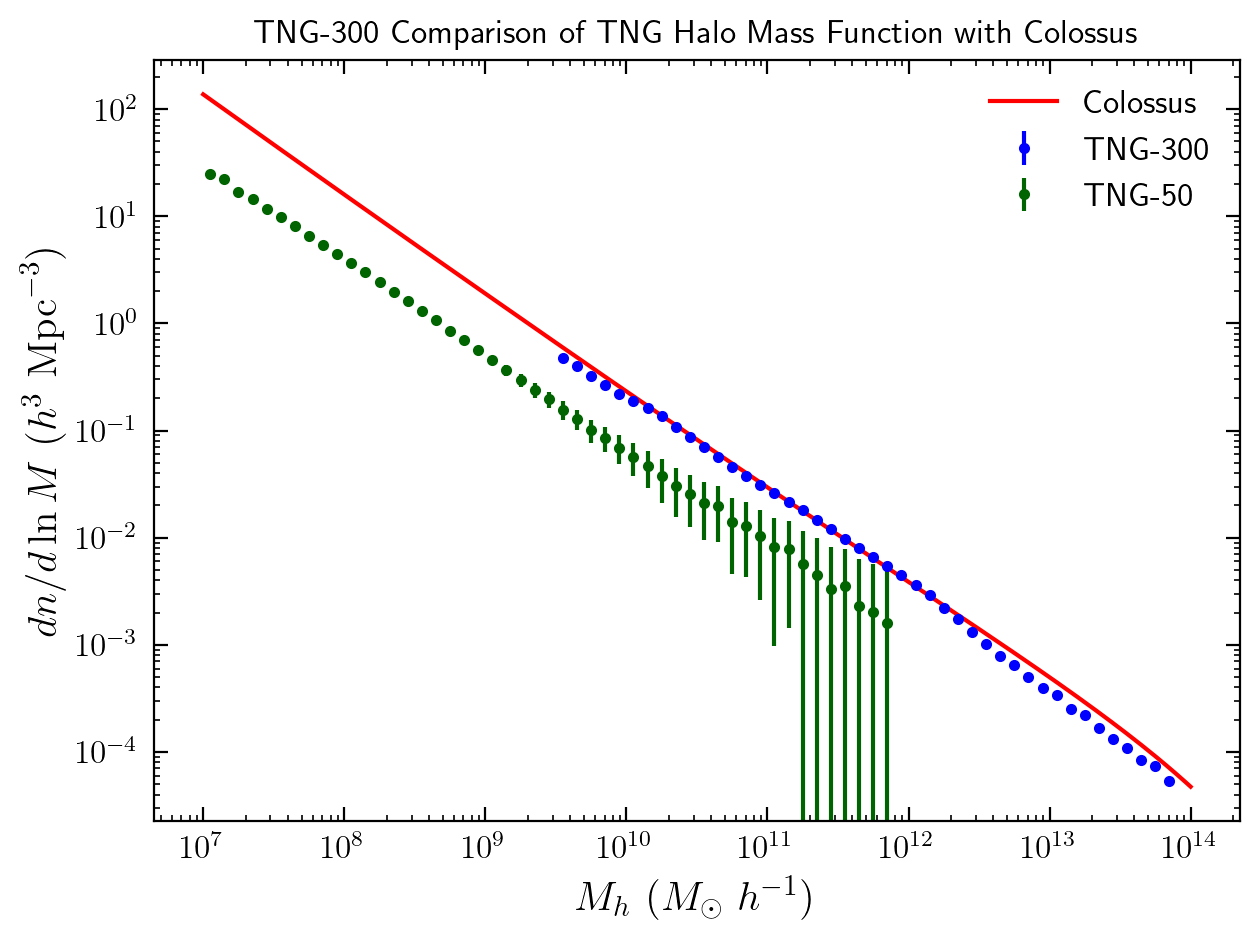

In [12]:
# Calculate the theoretical mass function using the 'angulo12' model
mass_ranges = np.logspace(7, 14, 200)
mf_theory = mass_function.massFunction(mass_ranges, 0., model = 'angulo12', q_out = 'dndlnM')

plt.plot(mass_ranges, mf_theory, 'r', label='Colossus')
plt.errorbar(m, dndM, yerr=errors, fmt='o', markersize=3, color='blue', label='TNG-300')
plt.errorbar(m2, dndM2, yerr=errors2, fmt='o', markersize=3, color='darkgreen', label='TNG-50')

plt.xlabel(r'$M_h \ (M_\odot \ h^{-1})$')
plt.ylabel(r'$dn/d\ln M \ (h^{3}\ \mathrm{Mpc}^{-3})$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('TNG-300 Comparison of TNG Halo Mass Function with Colossus')
plt.tight_layout()
plt.show()

Compared to Colossus, it is very clear that the halo mass function calculated using the TNG-300 data fits a lot better. Althought the TNG-300 does not perform well in the smaller mass regime, the TNG-50 simulation under predicts the number density of dark matter haloes per unit volume (if we are assuming Colossus to be ground truth of course). TNG-300 also shows much smaller error bars, allowing us to believe that it is more practical for determining the halo mass function.  

# Two Point Correlation Function

The two point correlation function is calculated using:  
\begin{equation}
\xi(r) \;=\; \frac{DD(r)}{RR(r)} \;-\; 1.
\end{equation}  

Where DD counts of pairs of galaxies (in bins of separation) in the data catalog and RR is the count of pairs of galaxies as a function of separation in the random catalog. This equation was introduced by [Hamilton 1998](https://ui.adsabs.harvard.edu/abs/1998ASSL..231..185H/abstract). 

Below I demonstrate a way to calculate this two point correlation function. Note that there are some packages that may do this for you, but for the sake of not dealing with changing versions of packages to make them compatible with each other, I show how to do this by hand. 

The key ideas for developing this algorithm is to: 
1) Pack the x,y,z coordinates into a cKDTree. We specify that the box is periodic so that any boundary conditions are handeled correctly. We say that N is the total number of points. 
2) For each bin edge $r_i$, we return the total number of unique pairs with a separation smaller than $r_i$. We ignore self pairs, and count each pair only once. 
3) Take the differences of the cumulative counts so that we get the number of pairs with separation between $r_i$ and $r_{i+1}$. 
4) Multiply the R pairs with the volume of the spherical shell. 
5) If the data has more pairs than random, then the correlation function is positive, else, it is negative. 
6) We compute the midpoint of each [$r_i$, $r_{i+1}$]. 
 

In [13]:
def two_point_cf(positions, r_bins, boxsize):
    """
    Two-point CF estimator xi(r) = DD/RR - 1 for a periodic box.

    Parameters
    ----------
    positions : ((N,3) array) - Galaxy (or halo) positions in a periodic cube.
    r_bins : (array like) - Monotonic array of bin edges. 
    boxsize : (float) - Side length of the periodic cube.

    Returns
    -------
    r_avg : (array) - Bin mid‑points.
    xi    : (array) Correlation in each bin.
    DD    : (array) Number of unique data-data pairs per bin.
    RR    : (array) Expected random-random counts per bin (analytic).
    """

    tree = cKDTree(positions, boxsize=boxsize)
    N = len(positions)

    cum_DD = tree.count_neighbors(tree, r_bins, cumulative=True) # cumulative number of pairs in each bin

    DD = np.diff(cum_DD) # unique data-data pairs in each bin

    # analytic RR
    N_pairs = N*(N-1)/2.0
    shell_vol = ((4/3)*np.pi) * (r_bins[1:]**3 - r_bins[:-1]**3)
    volume = boxsize**3
    RR = N_pairs * (shell_vol / volume)

    # xi = DD/RR – 1
    xi = DD/RR - 1.0  
    r_avg = 0.5*(r_bins[:-1] + r_bins[1:])

    return r_avg, xi, DD, RR


In [14]:
# Add 'SubhaloPos' to load positions (in code units, typically in kpc/h or Mpc/h depending on the simulation)
fields = ['SubhaloMass', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloGasMetallicity', 'SubhaloPos']
subhalos300 = il.groupcat.loadSubhalos(basePath, snap, fields=fields)
subhalos50 = il.groupcat.loadSubhalos(basepath2, snap, fields=fields)

# Extract positions (assuming the positions are stored as an (N,3) array)
positions = subhalos300['SubhaloPos']  # each row: [x, y, z] in simulation units
positions2 = subhalos50['SubhaloPos']  # each row: [x, y, z] in simulation units

# Convert positions to physical units (Mpc/h)
positions = positions / 1000.0  # convert to Mpc/h
positions2 = positions2 / 1000.0  # convert to Mpc/h

In [15]:
# using the full set of positions for TNG-300:
x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]

# using the full set of positions for TNG-50:
x2 = positions2[:, 0]
y2 = positions2[:, 1]
z2 = positions2[:, 2]


print(np.shape(x), np.shape(y), np.shape(z))
print(np.shape(x2), np.shape(y2), np.shape(z2))

(14485709,) (14485709,) (14485709,)
(5688113,) (5688113,) (5688113,)


In [16]:
# Define simulation box size (in h^-1 Mpc)
boxsize = 205.0
boxsize2 = 51.7

# Wrap positions to ensure periodic boundary conditions
x_wrapped = x % boxsize
y_wrapped = y % boxsize
z_wrapped = z % boxsize

x_wrapped2 = x2 % boxsize2
y_wrapped2 = y2 % boxsize2
z_wrapped2 = z2 % boxsize2

# Combine the wrapped positions into one (N,3) array.
positions_wrapped = np.column_stack((x_wrapped, y_wrapped, z_wrapped))
positions_wrapped2 = np.column_stack((x_wrapped2, y_wrapped2, z_wrapped2))


# Subsample the positions to reduce computation time for the two-point correlation function.
subsample_fraction = 0.01     # This value is adjustable, but I selected one that could run my data in a sustainable amount of time.
N = positions.shape[0]
N2 = positions_wrapped2.shape[0]

indices = np.random.choice(N, size=int(N * subsample_fraction), replace=False)   
indices2 = np.random.choice(N2, size=int(N2 * subsample_fraction), replace=False)

positions_wrapped_sub = positions_wrapped[indices]                  # Subsampled positions for TNG-300
positions_wrapped_sub2 = positions_wrapped2[indices2]               # Subsampled positions for TNG-50



# Define the bin edges for the two-point correlation function.
r_min = 1.0    # minimum separation (h^-1 Mpc)
r_max = 50.0   # maximum separation (h^-1 Mpc)
nbins = 20
r_bins = np.linspace(r_min, r_max, nbins + 1)


# Computing the 2 point correlation functions
r_avg, xi_vals, DD_counts, RR_counts = two_point_cf(positions_wrapped_sub, r_bins, boxsize)
r_avg2, xi_vals2, DD_counts2, RR_counts2 = two_point_cf(positions_wrapped_sub2, r_bins, boxsize2)


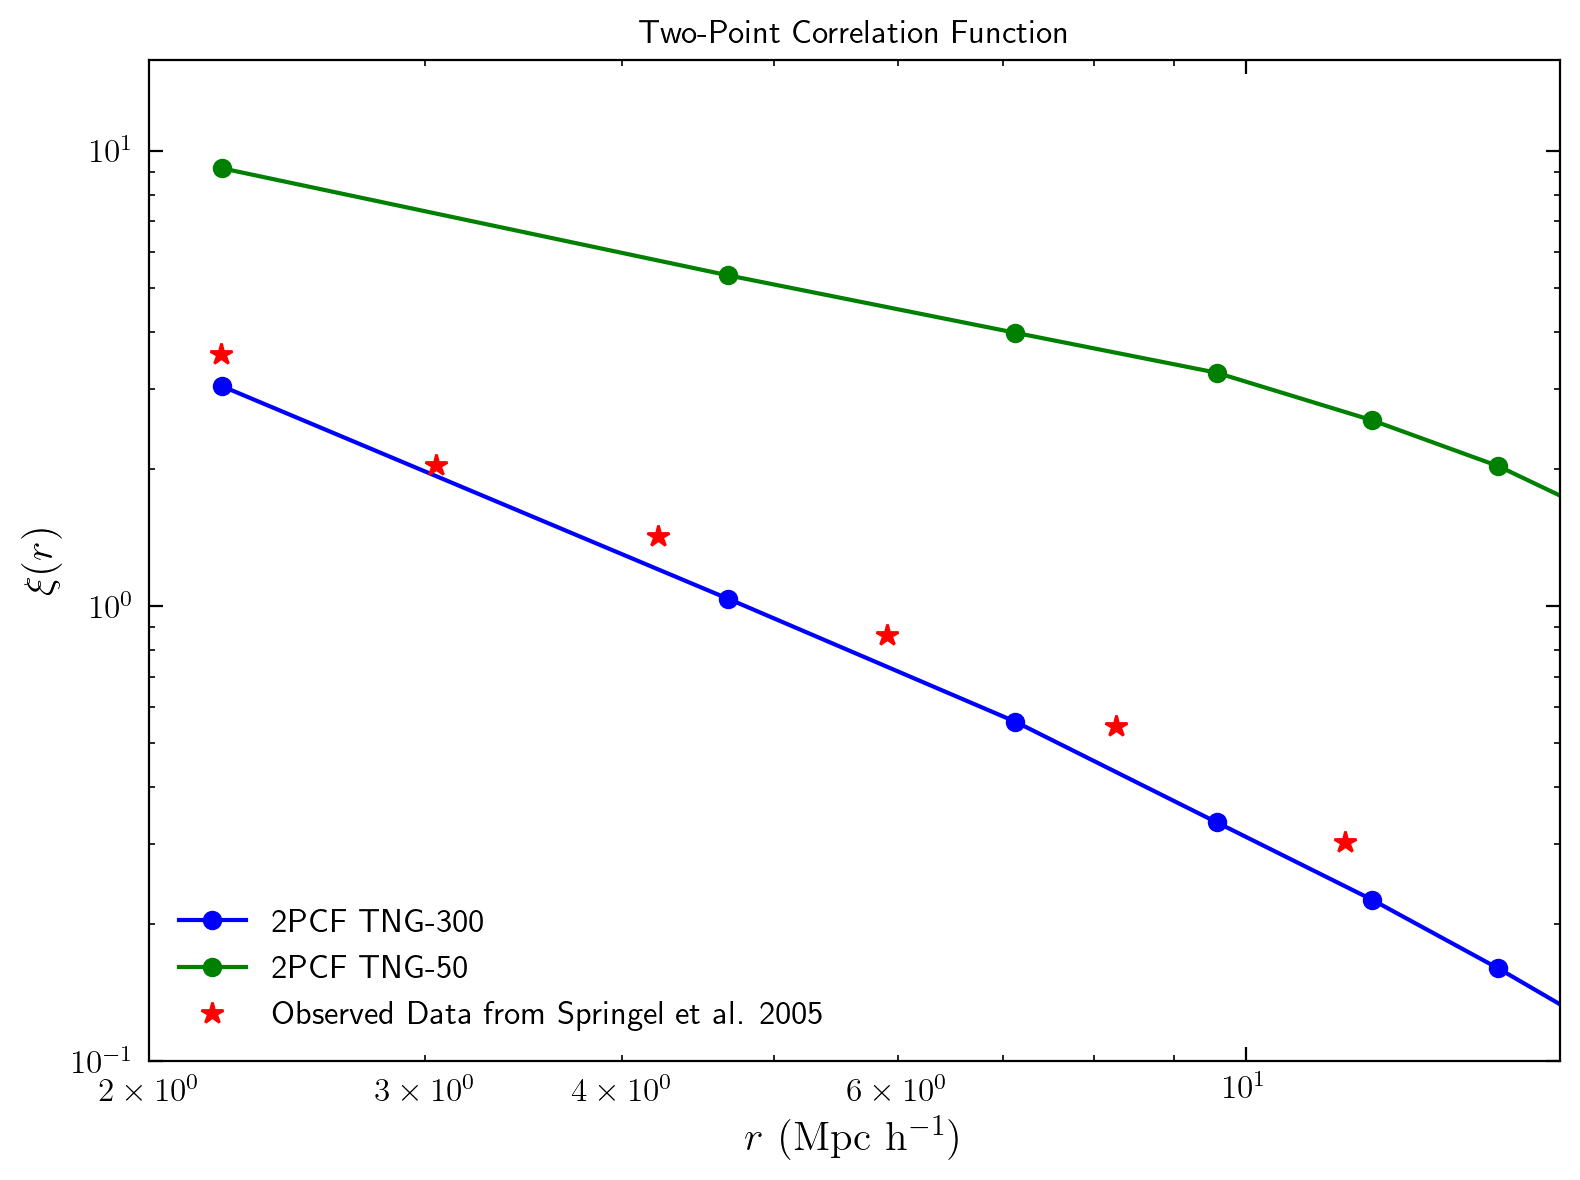

In [ ]:
# PLOTTING 
# offset !!! Figure is off by 1 on the y direction for the TNG300 2PCF (I PLOTTED THIS WITH THE OFFSET)
plt.figure(figsize=(8, 6))
plt.plot(r_avg, xi_vals-1 , 'o-', color='blue', label='2PCF TNG-300')
plt.plot(r_avg2, xi_vals2, 'o-', color='green', label='2PCF TNG-50')
plt.plot(obs['x'], obs['y'], '*', color='red', ms = 8, label='Observed Data from Springel et al. 2005')
plt.xlabel(r'$r \ (\rm{Mpc} \ h^{-1})$')w
plt.ylabel(r'$\xi(r)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(2, 10**(1.2))
plt.ylim(1e-1,10**(1.2))
plt.title('Two-Point Correlation Function')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Based on the results shown above, I am only able to reproduce the 2-point correlation function by using the TNG-300 dataset. This is very similar to the one shown in Figure 4 of [Springel et al. 2005](https://ui.adsabs.harvard.edu/abs/2005Natur.435..629S/abstract) .

There is an offset of 1 along the y direction for our TNG-300 2PCF. As for the TNG=50 dataset, we obtain a similar slope, but with a greater offset. Overall, it is clear the TNG-300 is able to reproduce the results that we expect to have better than TNG-50. 

# Calculation of the Mass–σ Relation

In order to calculate the mass sigma relation, we begin by considering the amplitude of density fluctuations on a given mass scale \(M\) by through its comoving raidius given by

\begin{equation}
R(M) \;=\; \left(\frac{3M}{4\pi\,\bar\rho_m}\right)^{1/3},
\end{equation}

where $(\bar \rho_m)$ is the mean matter density of the Universe today.  The variance

\begin{equation}
\sigma^2(R) \;=\; \langle \delta^2 \rangle,
\end{equation}

gives us the root mean square fractional overdensity where density field is smoothed on that scale. This is computed by filtering the linear matter power spectrum $(P(k))$ with a real‑space top‑hat window of radius $R$.

---

### What is needed

1. **Matter power spectrum** \(P(k)\)  
   Encodes the two‑point statistics of the linear density field in Fourier space:
   \begin{equation}
   \bigl\langle \tilde\delta(\mathbf{k})\,\tilde\delta^*(\mathbf{k}')\bigr\rangle
     = (2\pi)^3\,\delta_D(\mathbf{k}-\mathbf{k}')\,P(k).
   \end{equation}

2. **Top‑hat window function**  
   In real space a sharp‑edged sphere of radius R corresponds in k‑space to 
   \begin{equation}
        W(x) = {3 (\sin{x} - x \cos{x}) \over x^3},
   \end{equation}
 where x = Rk.

3. **Variance integral**  
   Putting it all together, the mass variance is
   \begin{equation}
   \sigma^2(R)
     = \int\frac{d^3k}{(2\pi)^3}\;W^2(kR)\,P(k)
     = \frac{1}{2\pi^2}\int_{0}^{\infty}W^2(kR)\,P(k)\,k^2\,dk.
   \end{equation}

---

### Final expression

\begin{equation}
\sigma^2\bigl(R(M)\bigr)
= \frac{1}{2\pi^2}\int_{0}^{\infty}W^2\bigl(k\,R(M)\bigr)\;P(k)\;k^2\,dk,
\qquad
W(x)=\frac{3\,[\sin x - x\cos x]}{x^3}.
\end{equation}

---

### Reasons why it matters:

- It is relevant to Halo abundance as in the Press–Schechter theory, the combining number denisty of halos of a specific mass, depends on the $\sigma(M)$ and its correlation to the critical collapse threshold. 
- It can tell us information on how rare a halo mass is. 
- Links clustering amplitude of haloes to their masses. 

In [18]:
mass_mask = (mh > 1e9) & (mh < 1e15)       # mass mask for TNG-300
mass_mask2 = (mh2 > 1e7) & (mh2 < 1e12)    # mass mask for TNG-50
print(mh[mass_mask], np.shape(mh[mass_mask]), type(mh[mass_mask]))

[3.63332893e+14 8.96404344e+12 4.94986278e+12 ... 1.07552538e+09
 1.03569114e+09 1.11535962e+09] (13336700,) <class 'numpy.ndarray'>


In [19]:
# Defining constant values
G = const.G                                        
h100 = 0.677
Om0 = 0.1424/h100**2
Ob0 = 0.0224/h100**2
ns = 0.967
sigma8 = 0.81
zeq = 3387.
keq = 0.01034/h100 # in h Mpc^-1
Tcmb0 = 2.726 # in K
delta_c = 1.69

rho_avg_now = Om0 * ( 3 * (h100*100*(u.km/u.s/u.Mpc))**2 / (8 * np.pi * G) )  

################

# Masses and radii
masses = mh[mass_mask] * u.Msun          # for TNG-300
masses2 = mh2[mass_mask2] * u.Msun        # for TNG-50
log_masses = np.log10(masses.value)
log_masses2 = np.log10(masses2.value)

# Create evenly spaced log-mass indices for TNG-300 and TNG-50
evenly_spaced_log_indices = np.linspace(log_masses.min(), log_masses.max(), 1000)
evenly_spaced_log_indices2 = np.linspace(log_masses2.min(), log_masses2.max(), 1000)

# Convert log-mass indices to physical masses
masses = 10**evenly_spaced_log_indices * u.Msun
masses2 = 10**evenly_spaced_log_indices2 * u.Msun

R = ( (3 * masses / (4 * np.pi * rho_avg_now))**(1/3) ).to(u.Mpc) 
R2 = ( (3 * masses2 / (4 * np.pi * rho_avg_now))**(1/3) ).to(u.Mpc)


#################

# Calculate the linear power spectrum 
k = np.logspace(-5, 4, 901) # in comoving h/Mpc
Tk = power_spectrum.modelEisenstein98(k, h100, Om0, Ob0, Tcmb0)


In [20]:
# sigma squared function
def sig2( logk, R ):
    ak = 10.**logk
    T = Tk_int(ak)
    Pk = ak**ns * T**2
    x = ak * R
    W2 = (3.*(np.sin(x)-x*np.cos(x))/x**3)**2
    f = W2/(2.*np.pi**2)*Pk*ak**2
    return f*ak*np.log(10.)

Tk_int = interp1d(k, Tk, kind='cubic')            # Interpolate Tk

# Sigma 8 calculation
s2 = quad(sig2, -5., 4., args=(8.0,))[0]          # R=8 for sigma8 normalization
A = sigma8**2 / s2

# Sigma function over all R with the normalization A from sigma8
def sigma(R):
    result = A * quad(sig2, -5., 3., args=(R,))[0]
    return np.sqrt(result)


#################################


# Calculate sigma for each R
sigma_vals = np.array([sigma(r.value) for r in R])
sigma_vals2 = np.array([sigma(r.value) for r in R2])

# Sort the masses and sigma values for TNG-300 and TNG-50
sorted_indices = np.argsort(masses.value)
sorted_indices2 = np.argsort(masses2.value)

sorted_masses = masses.value[sorted_indices]
sorted_masses2 = masses2.value[sorted_indices2]

sorted_sigma_vals = sigma_vals[sorted_indices]
sorted_sigma_vals2 = sigma_vals2[sorted_indices2]


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/3418155445.py:1: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(masses.value, sigma_vals, '-.', label='Computed $\sigma(M) TNG-300$', color='plum')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/3418155445.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(masses2.value, sigma_vals2, '--', ms=0.2, label='Computed $\sigma(M) TNG-50$', color='purple')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/

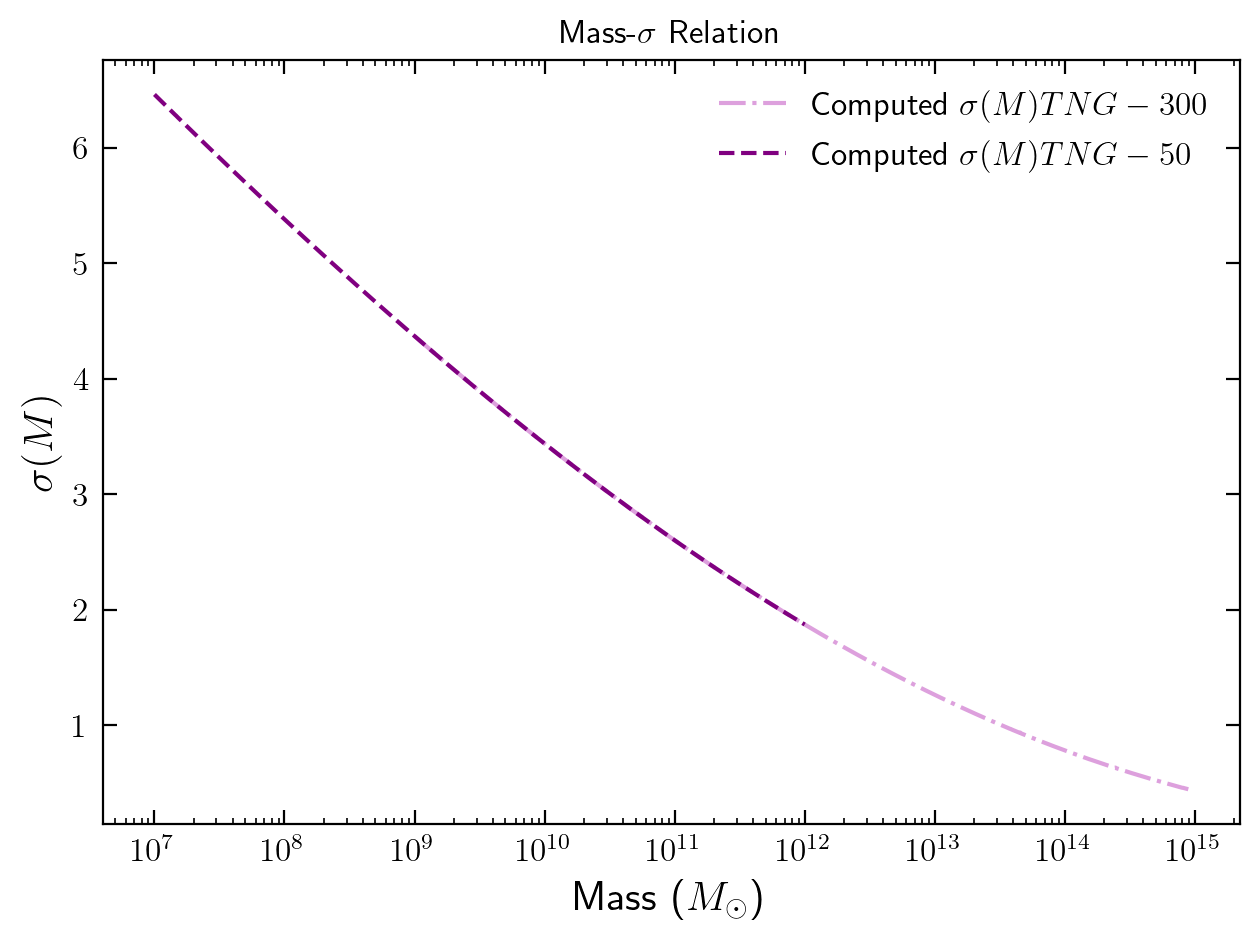

In [21]:
plt.plot(masses.value, sigma_vals, '-.', label='Computed $\sigma(M) TNG-300$', color='plum')
plt.plot(masses2.value, sigma_vals2, '--', ms=0.2, label='Computed $\sigma(M) TNG-50$', color='purple')
plt.xscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('$\sigma(M)$')
plt.title('Mass-$\sigma$ Relation')
plt.legend()
plt.tight_layout()
plt.show()

The mass sigma relation that we are able to obatin looks beutifully and almost identical to the one we had previously studied in class. The overalap between TNG50 and TNG300 is clar in this case. By using both simulations we are able to obtain a clear relationship over the mass ranges of $10^7 - 10^{15} M_{\odot}$

# Numerically Obtaining $\frac{d\ln\sigma(M)}{d\ln{M}}$

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/1812767329.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sorted_masses, dln_sigma_dlnM, '.', color='plum', label='$dln(\sigma)/dln(M) \ TNG-300$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/1812767329.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sorted_masses2, dln_sigma_dlnM2, '.', color='purple', label='$dln(\sigma)/dln(M) \ TNG-50$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/1812767329.py:15: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass ($M_{\odot})$')


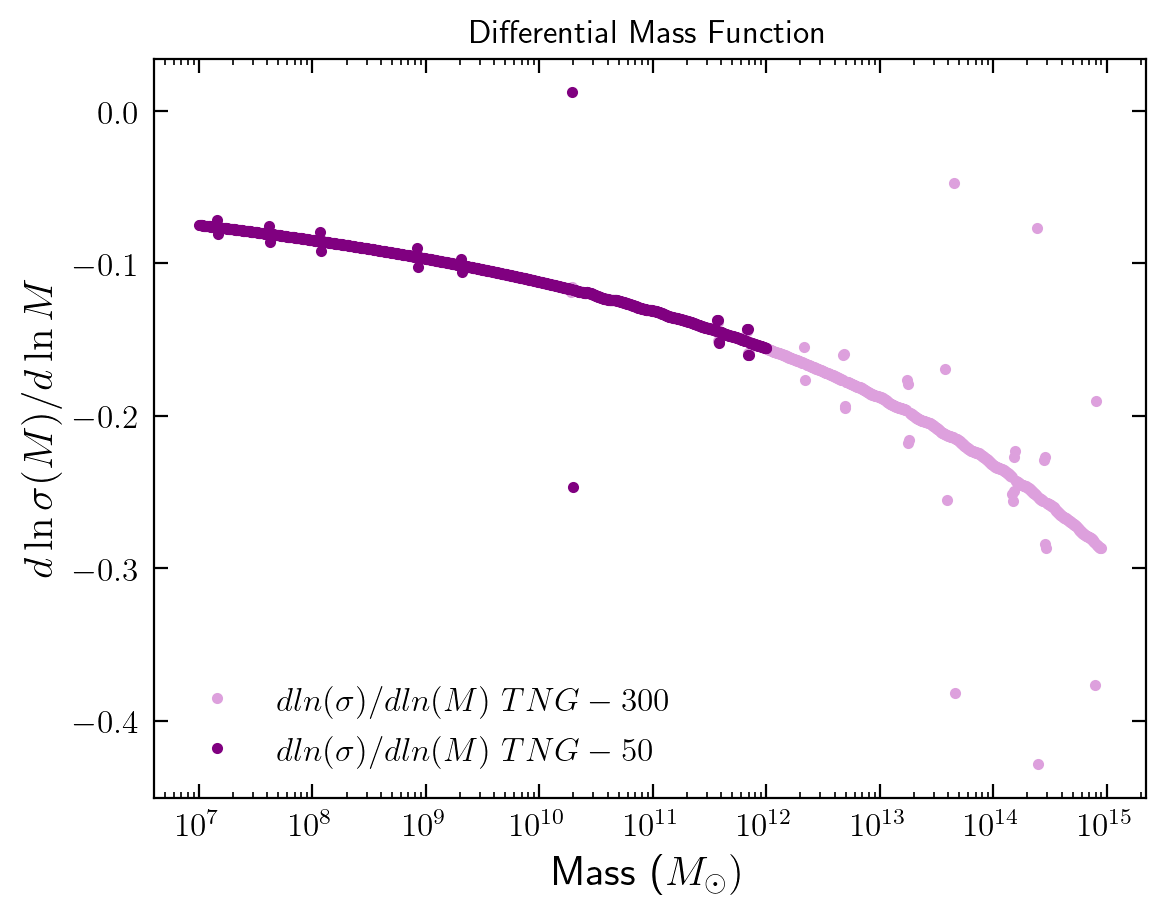

In [22]:
log_masses = np.log(sorted_masses)  # Take the natural logarithm of the mass values
log_masses2 = np.log(sorted_masses2)  # Take the natural logarithm of the mass values for TNG-50

# Interpolate sigma(M) vs ln(M)
sigma_interp = interpolate.interp1d(np.unique(log_masses), np.unique(sorted_sigma_vals), kind='cubic', fill_value="extrapolate")
sigma_interp2 = interpolate.interp1d(np.unique(log_masses2), np.unique(sorted_sigma_vals2), kind='cubic', fill_value="extrapolate")

# Differentiate the interpolated function
dln_sigma_dlnM = np.gradient(np.log(sorted_sigma_vals), log_masses)
dln_sigma_dlnM2 = np.gradient(np.log(sorted_sigma_vals2), log_masses2)

# Plot the differential mass function
plt.plot(sorted_masses, dln_sigma_dlnM, '.', color='plum', label='$dln(\sigma)/dln(M) \ TNG-300$')
plt.plot(sorted_masses2, dln_sigma_dlnM2, '.', color='purple', label='$dln(\sigma)/dln(M) \ TNG-50$')
plt.xlabel('Mass ($M_{\odot})$')
plt.ylabel(r'$d\ln\sigma(M)/d\ln{M}$')
plt.xscale('log')
# plt.ylim(-0.18,-0.075)
plt.title('Differential Mass Function')
plt.legend(loc='best')
plt.show()


The differential mass function that we obtan is also similar to the analytical one we had previously calculated in class. However, it is clear that in the higher mass range, we get very noisy data. However, I am certain that this is a result of pythons integrating limitations. These values get blown out of proportion when integrating, and are even further recognizable in the log scale. 

# Cumulative $n(>M)$ and differential $\frac{dn}{d\ln{M}}$ mass functions, analytical calculation

The number density of dark matter halos in a large volume of the universe is obtained by differentiating $F(>M)$ with respect to $M$ and multiplying by the average number density $\bar{\rho}/M$:

$$ \frac{dn}{dM} = -\sqrt{2\over \pi} \, {\bar{\rho} \over M^2} \,
       {\delta_c \over \sigma(M)} \, \frac{d\ln{\sigma(M)}}{d\ln{M}} \,
       \exp{\left[-{\delta_c^2 \over 2\sigma^2(M)}\right]} $$
       

The cumulative number density of halos above a given mass $M$ is

$$ n(>M) = \int_M^\infty \frac{dn}{dM}\, dM $$


In [23]:
# Calculating the cumulative number density of halos 

def dn_dM(M):
    # Interpolate sigma(M) and dln_sigma_dlnM for the given mass M
    sigma_M = np.interp(np.log(M), log_masses, sigma_vals)
    dln_sigma_dlnM_M = np.interp(np.log(M), log_masses, dln_sigma_dlnM)
    # Calculate dN/dM for the given mass M
    result = - (np.sqrt(2 / np.pi) * (rho_avg_now.to(u.Msun / u.Mpc**3).value / M**2) *
                (delta_c / sigma_M) * dln_sigma_dlnM_M *
                np.exp(- (delta_c**2 / (2 * sigma_M**2))))
    
    return result  # units of 1/Msun/Mpc^3

def dn_dM_der(M):
    # Interpolate sigma(M) and dln_sigma_dlnM for the given mass M
    sigma_M = np.interp(np.log(M), log_masses, sigma_vals)
    dln_sigma_dlnM_M = np.interp(np.log(M), log_masses, dln_sigma_dlnM)
    
    # Calculate dN/dM for the given mass M
    result = - M * (np.sqrt(2 / np.pi) * (rho_avg_now.to(u.Msun / u.Mpc**3).value / M**2) *
                (delta_c / sigma_M) * dln_sigma_dlnM_M *
                np.exp(- (delta_c**2 / (2 * sigma_M**2))))
    
    return result  # units of 1/Mpc^3

# Integrate from M to infinity
def cumulative_number_density(M):
    if M < 10**(9.5):
        return quad(dn_dM, M, 10**(9.6))[0]
    else:
        return quad(dn_dM, M, 1e15)[0]


# Calculate cumulative number density for each mass for TNG-300
cumulative_density = np.array([cumulative_number_density(m) for m in sorted_masses])
cumulative_density_der = np.array([dn_dM_der(m) for m in sorted_masses])

# Calculate cumulative number density for each mass for TNG-50
cumulative_density2 = np.array([cumulative_number_density(m) for m in sorted_masses2])
cumulative_density_der2 = np.array([dn_dM_der(m) for m in sorted_masses2])

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2270287123.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(dn_dM, M, 10**(9.6))[0]
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2270287123.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(dn_dM, M, 10**(9.6))[0]
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2270287123.py:31: IntegrationWarning: The maximum number of subdivisio

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2765404119.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass $(M_\odot)$')


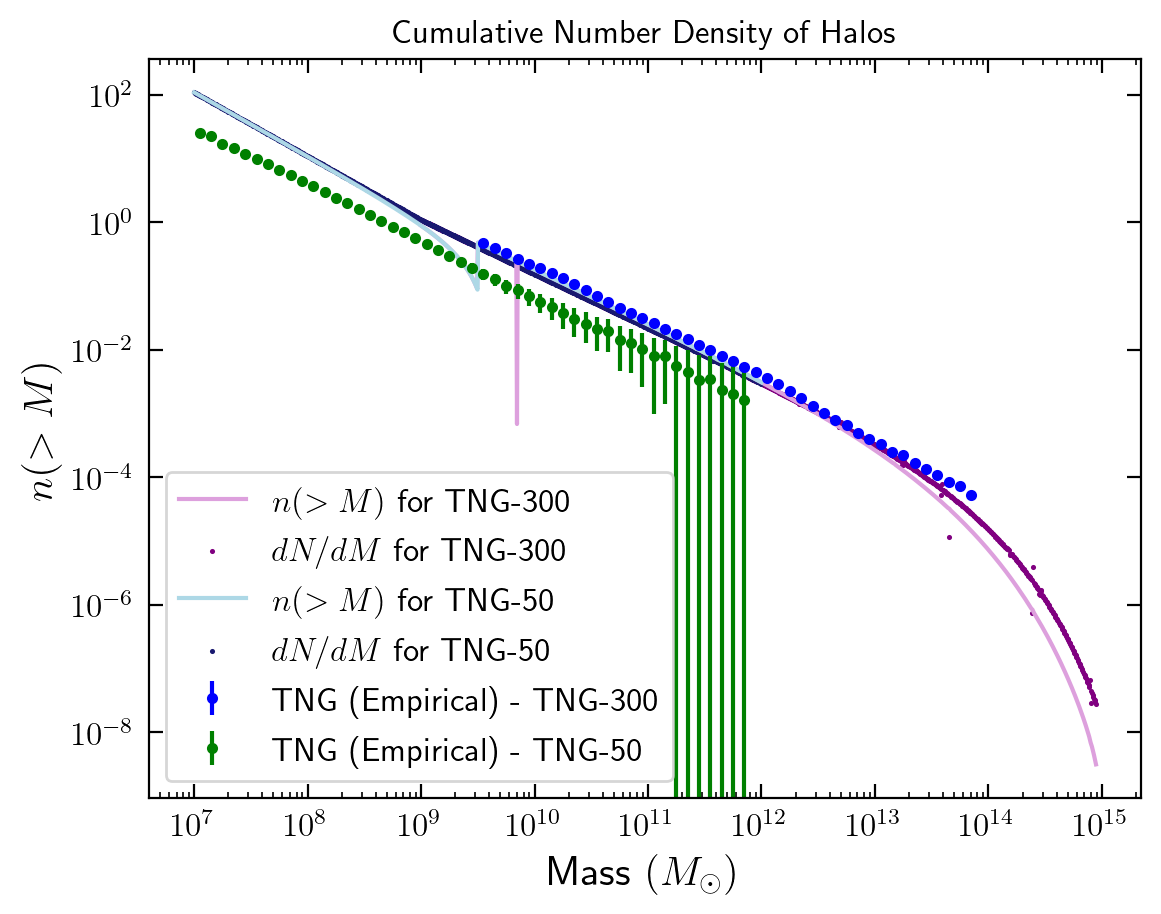

In [24]:
# Plotting the cumulative number density
plt.plot(sorted_masses, cumulative_density, color='plum', label='$n(>M)$ for TNG-300')
plt.scatter(sorted_masses,  cumulative_density_der, s=0.7, color='purple', label='$dN/dM$ for TNG-300')

plt.plot(sorted_masses2, cumulative_density2, color='lightblue', label='$n(>M)$ for TNG-50')
plt.scatter(sorted_masses2, cumulative_density_der2, s=0.7, color='midnightblue', label='$dN/dM$ for TNG-50')

plt.errorbar(m, dndM, yerr=errors, fmt='o', markersize=3, color='blue', label='TNG (Empirical) - TNG-300')
plt.errorbar(m2, dndM2, yerr=errors2, fmt='o', markersize=3, color='green', label='TNG (Empirical) - TNG-50')    

plt.xlabel('Mass $(M_\odot)$')
plt.ylabel('$n(>M)$')
plt.xscale('log')
plt.yscale('log')
plt.title('Cumulative Number Density of Halos')
plt.legend(frameon=True)
plt.show()

The culmulative number density for TNG50 gives results that are noisy at the range lower than $10^9$. This is a result from the inegration limitations built into python. This was the best result I could get, with the least amount of noise. Similarly, offset at the higher mass range for both TNG 300 plots is a results of the integral limitations. It is clear that by usin the relationship between both n and dN/dM we can estimate the cumulative number density at any given mass. TNG-50 would be optimal to be used for masses less that $10^{10}M_{\odot}$ and TNG-300 would be best for masses greater than this. 

Although this is an analytical approach to solving for the halo mass function, it is clear that it reproduces an even better result than the empirical method that I used above. Once again, TNG-300 does a better job at reproducing a halo mass function closer to what we expect. 

# Cumulative mass density $\rho(>M)$ and Comparing it with the analytical expression, $\rho_{th}(>M)$ 

We integrate the cumulative mass density $\rho(>M)$ and compare it with the analytical expression, $\rho_{th}(>M)$. 

In [25]:
def dn_dMM(M): 
    # Interpolate sigma(M) and dln_sigma_dlnM for the given mass M
    sigma_M = np.interp(np.log(M), log_masses, sigma_vals)
    dln_sigma_dlnM_M = np.interp(np.log(M), log_masses, dln_sigma_dlnM)
    
    # Calculate dN/dM for the given mass M
    result = - M * (np.sqrt(2 / np.pi) * (rho_avg_now.to(u.Msun / u.Mpc**3).value / M**2) *
                (delta_c / sigma_M) * dln_sigma_dlnM_M *
                np.exp(- (delta_c**2 / (2 * sigma_M**2))))

    return result  # units of 1/Mpc^3

def rho(M): 
    return quad(dn_dMM, M, 1e15)[0]
    

def rho_analytical(M):
    sigma_M = np.interp(np.log(M), log_masses, sigma_vals)
    result = rho_avg_now.to(u.Msun / u.Mpc**3).value * (1 - erf(delta_c / np.sqrt(2) / sigma_M)) 
    return result  # units of 1/Msun/Mpc^3


<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2941288841.py:12: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass $(M_\odot)$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/2008592598.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(dn_dMM, M, 1e15)[0]


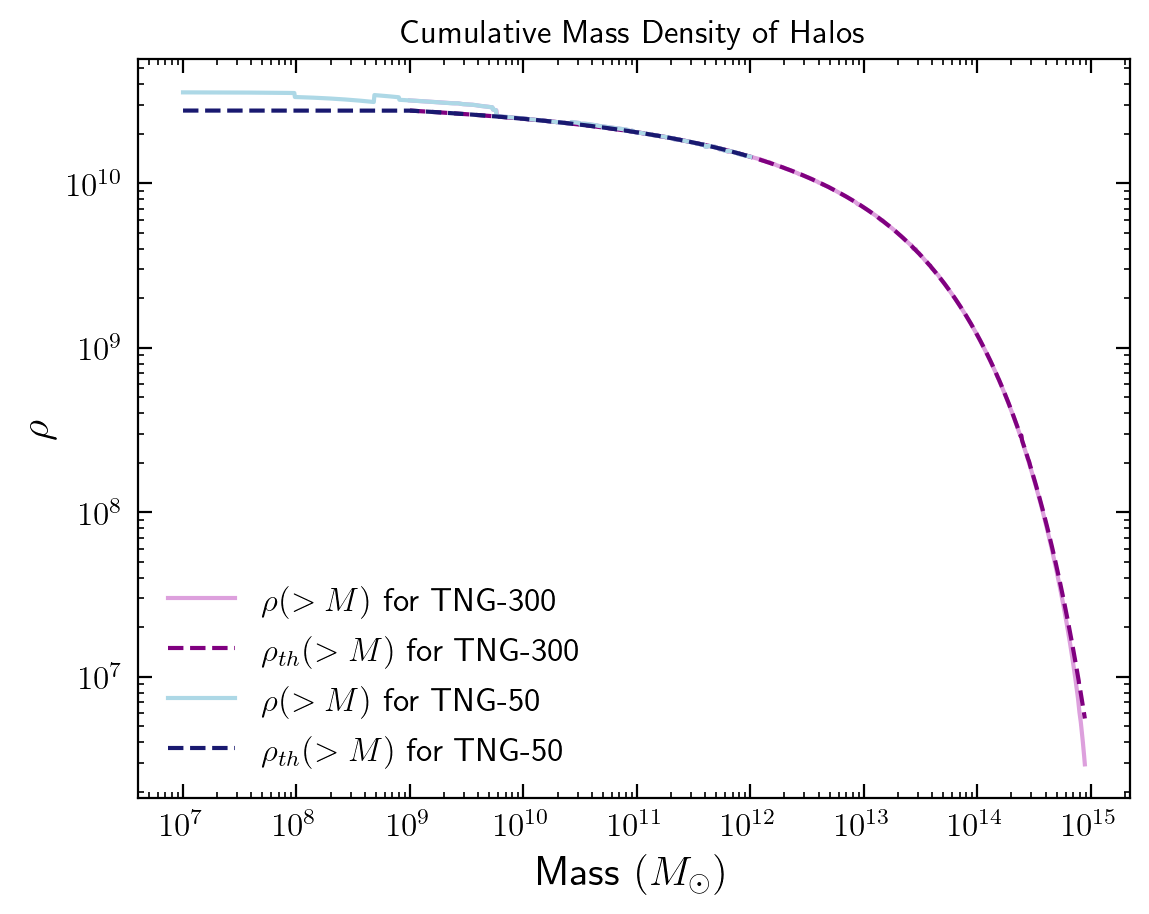

In [26]:
# Calculate the cumulative mass density
cumulative_mass_density = np.array([rho(m) for m in sorted_masses])
cumulative_mass_density2 = np.array([rho(m) for m in sorted_masses2])

# Plot the cumulative mass density
plt.plot(sorted_masses, cumulative_mass_density, color='plum', label=r'$ \rho(>M) $ for TNG-300')
plt.plot(sorted_masses, rho_analytical(sorted_masses), '--', color='purple', label=r'$ \rho_{th}(>M) $ for TNG-300')

plt.plot(sorted_masses2, cumulative_mass_density2, color='lightblue', label=r'$ \rho(>M) $ for TNG-50')
plt.plot(sorted_masses2, rho_analytical(sorted_masses2), '--', color='midnightblue', label=r'$ \rho_{th}(>M) $ for TNG-50')

plt.xlabel('Mass $(M_\odot)$')
plt.ylabel(r"$ \rho $")
plt.xscale('log')
plt.yscale('log')
plt.title('Cumulative Mass Density of Halos')
plt.legend()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/4045269084.py:5: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass $(M_\odot)$')


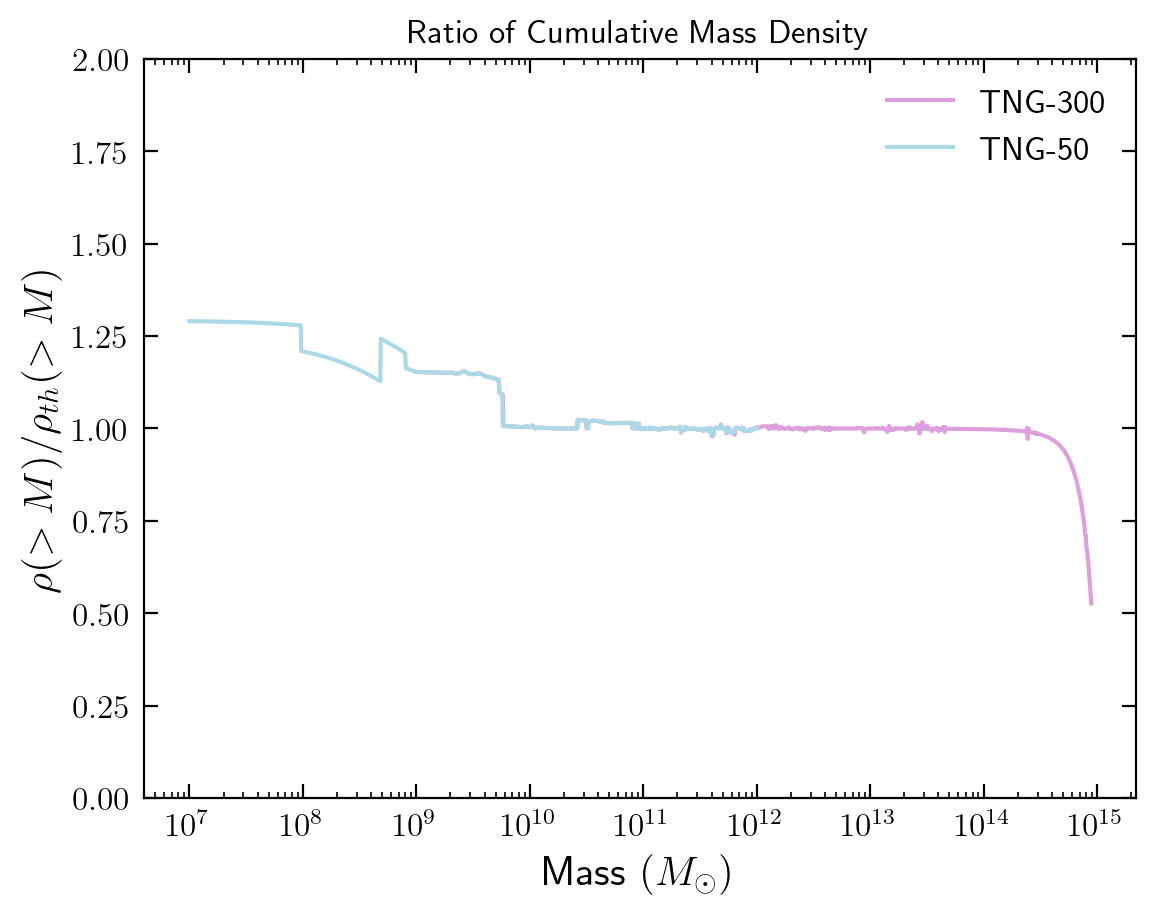

In [27]:
# Plotting the ratio between the two to check if they agree with each other
plt.plot(sorted_masses, cumulative_mass_density/rho_analytical(sorted_masses), color='plum', label='TNG-300')
plt.plot(sorted_masses2, cumulative_mass_density2/rho_analytical(sorted_masses2), color='lightblue', label='TNG-50')

plt.xlabel('Mass $(M_\odot)$')
plt.ylabel(r'$\rho(>M) / \rho_{th}(>M)$')
plt.xscale('log')
plt.ylim(0,2)
plt.title('Ratio of Cumulative Mass Density')
plt.legend()
plt.show()

It is clear that TNG 300 does a much better job at matching the theoretical solution. TNG50 breaks at the low mass end, but this could be due to the uncertainty from the python integrator, but I suspect that this has to do with simulation limitations. Regardless, they more or less agree within 1% (excluding the high noise from TNG-50 below mass $10^{10}M_{\odot}$). 


# Comparing results with stellar mass function from [Bell et al. 2003](https://ui.adsabs.harvard.edu/abs/2003ApJS..149..289B/abstract) with our Cumulative Mass Density Function while taking into account the ellipsoidal collapse modification. 

In [28]:
# masses = np.logspace(9, 15, 200) * u.Msun
phi0 = (4 * 10**(-3) * h100**3 * u.Mpc**(-3)).value
alpha = 1.1
M0 = (7 * 10**10 / h100 * u.Msun).value

f_b = Ob0 / Om0

In [29]:
sorted_masses, sorted_masses2
print(sorted_masses, sorted_masses2, np.shape(sorted_masses), np.shape(sorted_masses2))

[1.00001757e+09 1.01382206e+09 1.02781712e+09 1.04200537e+09
 1.05638947e+09 1.07097214e+09 1.08575611e+09 1.10074416e+09
 1.11593911e+09 1.13134381e+09 1.14696117e+09 1.16279411e+09
 1.17884561e+09 1.19511870e+09 1.21161642e+09 1.22834188e+09
 1.24529822e+09 1.26248863e+09 1.27991634e+09 1.29758463e+09
 1.31549681e+09 1.33365626e+09 1.35206639e+09 1.37073066e+09
 1.38965257e+09 1.40883568e+09 1.42828361e+09 1.44800000e+09
 1.46798855e+09 1.48825304e+09 1.50879726e+09 1.52962508e+09
 1.55074041e+09 1.57214722e+09 1.59384954e+09 1.61585144e+09
 1.63815706e+09 1.66077059e+09 1.68369629e+09 1.70693846e+09
 1.73050147e+09 1.75438975e+09 1.77860778e+09 1.80316014e+09
 1.82805141e+09 1.85328630e+09 1.87886953e+09 1.90480592e+09
 1.93110034e+09 1.95775774e+09 1.98478312e+09 2.01218157e+09
 2.03995823e+09 2.06811833e+09 2.09666715e+09 2.12561008e+09
 2.15495253e+09 2.18470004e+09 2.21485819e+09 2.24543266e+09
 2.27642917e+09 2.30785358e+09 2.33971177e+09 2.37200974e+09
 2.40475356e+09 2.437949

In [30]:
def dn_dMdM_stellar(M):
    result = phi0 * (M/M0)**(-alpha) * np.exp(-(M/M0)) / M0
    return result

def dn_dMdM__stellar_der(M):
    result = M * phi0 * (M/M0)**(-alpha) * np.exp(-(M/M0)) / M0
    return result

def stellar_cumulative_density(M):
    return quad(dn_dMdM_stellar, M, 1e14)[0]

stellar_cumulative_density_output = np.array([stellar_cumulative_density(f_b * m) for m in sorted_masses])
stellar_cumulative_density_der = np.array([dn_dMdM__stellar_der(f_b * m) for m in sorted_masses])

stellar_cumulative_density_output2 = np.array([stellar_cumulative_density(f_b * m) for m in sorted_masses2])
# stellar_cumulative_density_der2 = np.array([dn_dMdM__stellar_der(f_b * m) for m in sorted_masses2])

###################################################

A = 0.322
q = 0.3
nu = delta_c / sigma_vals
nu_tilda = 0.84 * nu
f_ps = np.sqrt(2/np.pi) * nu * np.exp(-nu**2/2)
f_EC = A * (1 + 1 / ((nu_tilda)**(2*q)) ) * f_ps


dlnnu_dlnM = np.gradient(np.log(nu), np.log(sorted_masses))

def dn_dMdM_dm_halo(M):
    # interpolate dlnnu/dlnM, f_ps, and f_EC for the given mass M
    dlnnu_dlnM_M = np.interp(np.log(M), np.log(sorted_masses), dlnnu_dlnM)
    f_ps_M = np.interp(np.log(M), np.log(sorted_masses), f_ps)
    f_EC_M = np.interp(np.log(M), np.log(sorted_masses), f_EC)
    result = rho_avg_now.to(u.Msun / u.Mpc**3).value / M**2 * f_ps_M * dlnnu_dlnM_M * f_EC_M
    return result 

def dn_dMdM_dm_halo_der(M):
    # use the definition that the derivative in log-space is simply M times the original function
    return M * dn_dMdM_dm_halo(M)



def dmhalo_cumulative_density(M):
    return quad(dn_dMdM_dm_halo, M, 10**(13.91) )[0]


dmhalo_cumulative_density_output = np.array([dmhalo_cumulative_density(f_b * m) for m in sorted_masses])
dmhalo_cumulative_density_der = np.array([dn_dMdM_dm_halo_der(f_b * m) for m in sorted_masses])

dmhalo_cumulative_density_output2 = np.array([dmhalo_cumulative_density(f_b * m) for m in sorted_masses2])
dmhalo_cumulative_density_der2 = np.array([dn_dMdM_dm_halo_der(f_b * m) for m in sorted_masses2])


/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/1476347191.py:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(dn_dMdM_dm_halo, M, 10**(13.91) )[0]
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/1476347191.py:45: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(dn_dMdM_dm_halo, M, 10**(13.91) )[0]


<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/3660905168.py:10: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass $(M_\odot)$')


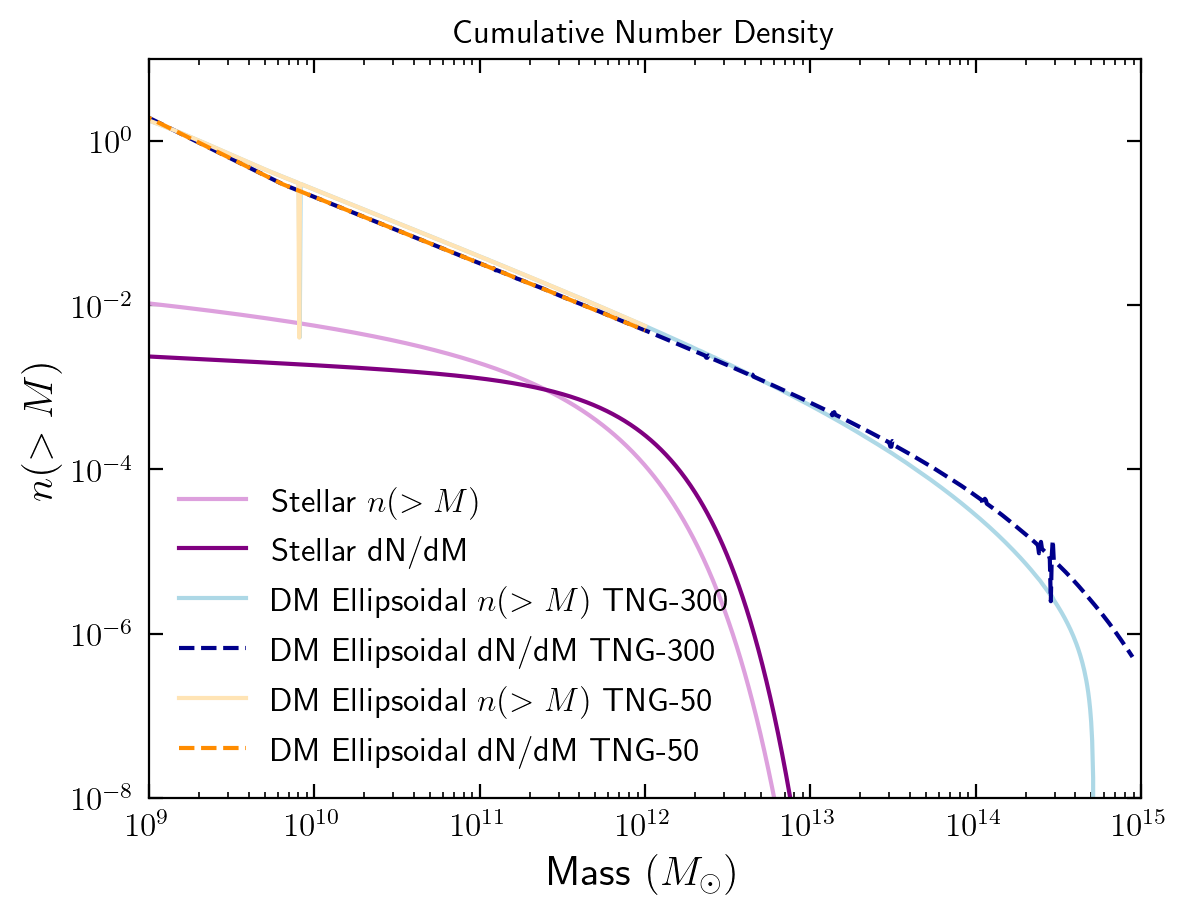

In [31]:
plt.plot(sorted_masses, stellar_cumulative_density_output, color='plum', label=r'Stellar $n(>M)$')
plt.plot(sorted_masses,  stellar_cumulative_density_der, color='purple', label='Stellar dN/dM')

plt.plot(sorted_masses, dmhalo_cumulative_density_output, color='lightblue', label=r'DM Ellipsoidal  $n(>M)$ TNG-300')
plt.plot(sorted_masses,  dmhalo_cumulative_density_der, '--', color='darkblue', label='DM Ellipsoidal dN/dM TNG-300')

plt.plot(sorted_masses2, dmhalo_cumulative_density_output2, color='moccasin', label=r'DM Ellipsoidal  $n(>M)$ TNG-50')
plt.plot(sorted_masses2,  dmhalo_cumulative_density_der2, '--', color='darkorange', label='DM Ellipsoidal dN/dM TNG-50')

plt.xlabel('Mass $(M_\odot)$')
plt.ylabel(r'$n(>M)$')
plt.title('Cumulative Number Density')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e9, 1e15)
plt.ylim(1e-8, 1e1)
plt.legend()

From this we are able to get a very clear result between the stellar cumulative density and the DM haloes' one. The spikes that are shown at around $10^{10} M_{\odot}$ and $10^{14.2}M_{\odot}$ are purely due to python integration erros. These change as I mess around with the integration definition bounds, but the ones presented above where the least noisy. 
Both TNG-0 and TNG-300 seem appropriate for this approximation. 

# Calculation of the stellar mass of a galaxy associated with halo of mass $M$ (that is, not assuming $M_s = f_b M$)

<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_92068/1324876576.py:29: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass $(M_\odot)$')


Text(0.5, 1.0, 'Mass Ratio')

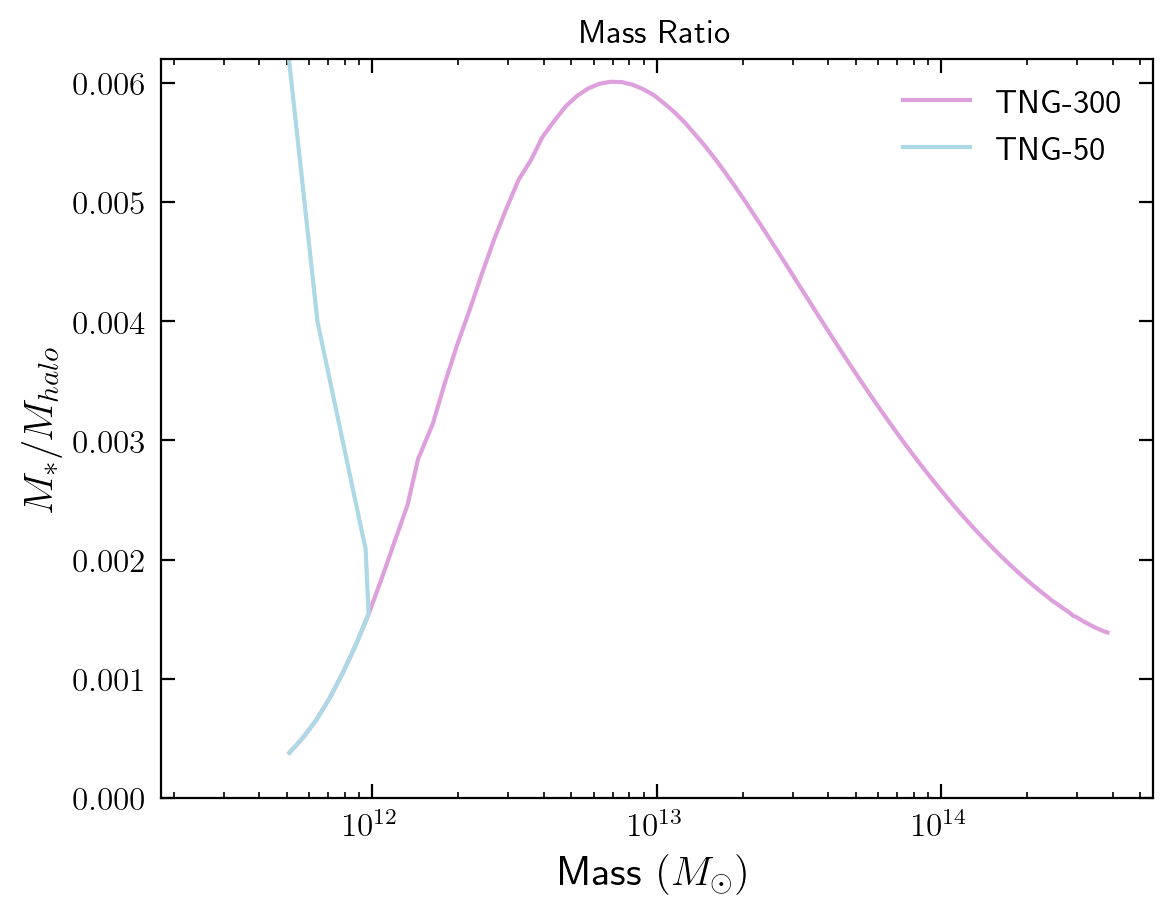

In [32]:
stellar_mass = interp1d(stellar_cumulative_density_output[:800], f_b * sorted_masses[:800], kind='cubic', bounds_error=False,        # don’t raise on out‑of‑bounds
    fill_value=np.nan ) # Interpolate stellar mass
stellar_mass2 = interp1d(stellar_cumulative_density_output2[:800], f_b * sorted_masses2[:800], kind='cubic', bounds_error=False,
    fill_value=np.nan ) # Interpolate stellar mass for TNG-50


stellar_mass_of_dm_cum = interp1d(dmhalo_cumulative_density_output, sorted_masses, kind='cubic', bounds_error=False,
    fill_value=np.nan)          # Interpolate DM halo mass
stellar_mass_of_dm_cum2 = interp1d(dmhalo_cumulative_density_output2, sorted_masses2, kind='cubic', bounds_error=False,
    fill_value=np.nan)          # Interpolate DM halo mass for TNG-50


# Now I need to find the ratio of the two
n_values = np.logspace(-6, -2, 100)
sm = stellar_mass(n_values)
dm = stellar_mass_of_dm_cum(n_values)
mass_ratio = sm / dm

n_values2 = np.logspace(-6, -2, 100)
sm2 = stellar_mass2(n_values2)
dm2 = stellar_mass_of_dm_cum2(n_values2)
mass_ratio2 = sm2 / dm2

plt.plot(stellar_mass_of_dm_cum(n_values), mass_ratio, color='plum', label='TNG-300')
plt.plot(stellar_mass_of_dm_cum2(n_values2), mass_ratio2, color='lightblue', label='TNG-50')
plt.legend()
plt.xscale('log')
plt.ylim(0, .0062)
plt.xlabel('Mass $(M_\odot)$')
plt.ylabel('$M_* / M_{halo}$')  
plt.title('Mass Ratio')

For this problem, only TNG-300 was able to reproduce the anticipated results. TNG-50 deviates heavilly from the tren dthat we expect to see. The peak of this curve is located at around $10^{13} M_{\odot}$, which is what we expect to see. 

# Summary 
In this notebook we test multiple cases to determine the applicability of TNG-50 and TNG-300 and to compare them both. Overall, TNG-300 is able to reproduce for of our expected results compared to TNG-50. This is evident in our Mass Ratio figure, the Ratio of Cumulative Density figure, and the Two Point Correlation Function. There are also a lot of limitations that I faced when trying to carry out several integrations in python, specially in the regime for which TNG-50 lies in. Regardless, the overall slope, and trends of the figures where more or less what we expected. 

The development of the 2PCF was the trickiest part. I had attempted using a predefined 2PCF from the package corrfunc, but I faced too many issues in my attempts at running it. I decided to research the function itself and try to understand how it works and write a simple algorithm that could mimic it. From my understanding, in order to have a successful run for your 2PCF, you need a large sample of data in order to beat the Poisson noise that comes in the function. However, due to computational time constraints, I had to limit my data to only use $N_{total} = 0.01 \times N$ where N is number of points. It would be interesting to see the performance of this algorithm on the complete dataset. 

As for the SFR, I did not find a clear distinction in it with respect to central haloes vs its satellites. Further analysis may be required to distinguish a specific trend, perhaps involving the study of star formation efficiency, or quenched fractions which will provide insights on environmental suppression. 
